<a href="https://colab.research.google.com/github/ceperueloaluis/Trabajo-de-investigaci-n-1.-de-bachillerato/blob/main/Copia_de_tarea1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de investigación IES Picarral

## Tarea 1: Descarga e integración de datos

### **Datos de calidad de aire**



In [ ]:
import os
import requests
import json
import pandas as pd
from glob import glob
import numpy #numpy.repeat

Primero, realizamos una llamada a la API por estación y guardamos cada resultado en un fichero JSON

In [ ]:
base_url = "https://zaragoza.es/sede/servicio/calidad-aire/estacion/diaria.json?" # COMPLETAR CON LA URL CORRECTA
stations = range(1, 13)
output_dir = "data/polut"

# Create folder if not exists
os.makedirs(output_dir, exist_ok=True)

contaminante = 8

for station_id in stations:
    print("Downloading station {station_id}...")

    # COMPLETAR CON LOS PARÁMETROS NECESARIOS
    params = {
        "fechaInicio": "01/01/2000",
        "fechaFin": "31/12/2024",
        "contaminante": 8
    }

    try:
        resp = requests.get(base_url, params=params)
        if resp.status_code == 200:
            file_path = os.path.join(output_dir, f"station_{station_id}.json")
            with open(file_path, "w", encoding="utf-8") as f:
                f.write(resp.text)
            print(f"✅ Saved to {file_path}")
        else:
            print(f"❌ Failed to download station {station_id} (HTTP {resp.status_code})")
    except requests.RequestException as e:
        print(f"⚠️ Error downloading station {station_id}: {e}")

✅ Saved to data/polut/station_1.json
✅ Saved to data/polut/station_2.json
✅ Saved to data/polut/station_3.json
✅ Saved to data/polut/station_4.json
✅ Saved to data/polut/station_5.json
✅ Saved to data/polut/station_6.json
✅ Saved to data/polut/station_7.json
✅ Saved to data/polut/station_8.json
✅ Saved to data/polut/station_9.json
✅ Saved to data/polut/station_10.json
✅ Saved to data/polut/station_11.json
✅ Saved to data/polut/station_12.json


Una vez tenemos los 12 ficheros descargados, debemos leerlos y transformarlos a un formato que nos permita tratar los datos

In [ ]:
# Ruta con los ficheros
folder = "/content/data/polut"

all_data = []

# Bucle para cada fichero
for i in range(1, 13):
    file_path = os.path.join(folder, f"station_{i}.json")

    # Leer fichero
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Transformar en un formato legible
    normal_data = pd.json_normalize(data["observation"])

    # Anyadir tabla a la lista
    all_data.append(normal_data)

# Unir todas las tablas en una
poluc_data = pd.concat(all_data, ignore_index=True)

# Cambiar "SIN DATOS" por "NA" (valor ausente)
poluc_data.loc[poluc_data["value"] == "SIN DATOS", "value"] = pd.NA
# Transformar el valor de NO2 en numérico
poluc_data["value"] = pd.to_numeric(poluc_data["value"], errors="coerce")
# Transformar la fecha a tipo de datos "fecha"
poluc_data["publicationDate"] = pd.to_datetime(poluc_data["publicationDate"])
# Eliminar las columnas que no necesitamos
poluc_data = poluc_data.drop(columns=["estado", "nivel", "nombre"], errors="ignore")
# Extraer el año de la fecha
poluc_data["year"] = poluc_data["publicationDate"].dt.year
# Extraer el mes de la fecha
poluc_data["month"] = poluc_data["publicationDate"].dt.month
# Como son datos diarios, los convertimos en mensuales calculando la media para cada mes
poluc_data = (
    poluc_data
    .groupby(["estacion", "year", "month"], as_index=False)
    .agg(mean_value=("value", "mean"))
)

# Cambiar el nombre a las columnas
poluc_data.columns = ["estacion", "year", "mes", "no2"]

csv_path = "/content/polucion_no2_mensual.csv"
poluc_data.to_csv(csv_path, index=False, encoding="utf-8")

# Descargar CSV
files.download(csv_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import os
import json
import pandas as pd
from google.colab import files

# Ruta con los ficheros JSON
folder = "/content/data/polut"

all_data = []

# Bucle para cada fichero (estaciones 1 a 12)
for i in range(1, 13):
    file_path = os.path.join(folder, f"station_{i}.json")

    # Leer fichero JSON
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Normalizar datos
    normal_data = pd.json_normalize(data["observation"])

    # Forzar número de estación según el fichero
    normal_data["estacion"] = i

    # Añadir a la lista
    all_data.append(normal_data)

# Unir todas las tablas
poluc_data = pd.concat(all_data, ignore_index=True)

# Cambiar "SIN DATOS" por NA
poluc_data.loc[poluc_data["value"] == "SIN DATOS", "value"] = pd.NA

# Convertir NO2 a numérico
poluc_data["value"] = pd.to_numeric(poluc_data["value"], errors="coerce")

# Convertir fecha
poluc_data["publicationDate"] = pd.to_datetime(poluc_data["publicationDate"])

# Eliminar columnas innecesarias
poluc_data = poluc_data.drop(columns=["estado", "nivel", "nombre"], errors="ignore")

# Extraer año y mes
poluc_data["year"] = poluc_data["publicationDate"].dt.year
poluc_data["month"] = poluc_data["publicationDate"].dt.month

# Pasar de datos diarios a mensuales (media)
poluc_data = (
    poluc_data
    .groupby(["estacion", "year", "month"], as_index=False)
    .agg(no2=("value", "mean"))
)

# Renombrar columnas
poluc_data.columns = ["estacion", "year", "mes", "no2"]

# Guardar CSV
csv_path = "/content/polucion_no2_mensual.csv"
poluc_data.to_csv(csv_path, index=False, encoding="utf-8")

# Descargar CSV
files.download(csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Datos de matriculaciones**

In [ ]:
import pandas as pd
import numpy as np

# ==============================
# 1. RUTA DEL ARCHIVO
# ==============================
matri_path = "/content/Matriculacionsc - Matriculacion.csv"

# ==============================
# 2. LEER CSV
# ==============================
# Codificación latin1 para evitar errores de caracteres
# Usamos header=3 para saltar las primeras 3 líneas de metadatos
matri_data = pd.read_csv(
    matri_path,
    encoding="latin1",
    sep=";",
    header=3
)

# La primera fila del DataFrame (que era la 4ª línea del archivo) contiene los nombres de las columnas
matri_data.columns = matri_data.iloc[0]

# Eliminar esa fila que ya se usó como cabecera
matri_data = matri_data[1:]

# ==============================
# 3. SELECCIONAR COLUMNAS
# ==============================
# La columna 'Año' viene mal codificada como 'AÃ±o' si no se maneja bien la codificación
# Pero con encoding='latin1' y header/iloc[0] debería ser 'Año'
matri_data = matri_data[["Año", "Periodo", "Zaragoza"]]

# Renombrar columnas correctamente
matri_data.columns = ["Año", "Mes", "Num_matr"]

# ==============================
# 4. CONVERTIR MESES A NÚMEROS
# ==============================
mapa_meses = {
    "Enero": 1,
    "Febrero": 2,
    "Marzo": 3,
    "Abril": 4,
    "Mayo": 5,
    "Junio": 6,
    "Julio": 7,
    "Agosto": 8,
    "Septiembre": 9,
    "Octubre": 10,
    "Noviembre": 11,
    "Diciembre": 12,
    "Anual": 13
}

matri_data["Mes"] = matri_data["Mes"].map(mapa_meses)

# Eliminar filas sin mes válido
matri_data = matri_data.dropna(subset=["Mes"])

# ==============================
# 5. LIMPIEZA DE TIPOS
# ==============================
matri_data["Año"] = matri_data["Año"].astype(int)
matri_data["Mes"] = matri_data["Mes"].astype(int)

# Limpiar y convertir Num_matr
matri_data["Num_matr"] = (
    matri_data["Num_matr"]
    .astype(str)
    .str.replace(".", "", regex=False)
    .str.replace(",", ".", regex=False)
    .str.strip()
)

matri_data["Num_matr"] = pd.to_numeric(
    matri_data["Num_matr"],
    errors="coerce"
)

matri_data = matri_data.dropna(subset=["Num_matr"])
matri_data["Num_matr"] = matri_data["Num_matr"].astype(int)

# ==============================
# 6. ORDENAR TABLA FINAL
# ==============================
matri_data = matri_data.sort_values(
    ["Año", "Mes"]
).reset_index(drop=True)

# ==============================
# 7. MOSTRAR TABLA COMPLETA
# ==============================
pd.set_option("display.max_rows", None)
display(matri_data)

# ==============================
# 8. GUARDAR RESULTADO FINAL
# ==============================
output_path = "/content/data/polut"
matri_data.to_csv(_path, index=False, encoding="utf-8")

from google.colab import files
files.download(output_path)

Año  Mes  Num_matr
0    2003    1      1502
1    2003    2      1234
2    2003    3      1598
3    2003    4      1625
4    2003    5      1744
5    2003    6      2122
6    2003    7      2370
7    2003    8      1160
8    2003    9      1467
9    2003   10      1755
10   2003   11      1814
11   2003   12      1948
12   2003   13     20339
13   2004    1      1500
14   2004    2      1799
15   2004    3      1901
16   2004    4      1742
17   2004    5      1940
18   2004    6      2506
19   2004    7      2532
20   2004    8      1290
21   2004    9      1625
22   2004   10      1851
23   2004   11      2015
24   2004   12      2160
25   2004   13     22861
26   2005    1      1688
27   2005    2      1803
28   2005    3      2208
29   2005    4      2264
30   2005    5      2213
31   2005    6      2659
32   2005    7      2836
33   2005    8      1689
34   2005    9      1846
35   2005   10      1919
36   2005   11      2239
37   2005   12      2296
38   2005   13     25660
39   2006    1      1682
40   2006    2      1935
41   2006    3      2385
42   2006    4      1866
43   2006    5      2286
44   2006    6      2566
45   2006    7      2596
46   2006    8      1619
47   2006    9      1892
48   2006   10      2065
49   2006   11      2205
50   2006   12      2060
51   2006   13     25157
52   2007    1      1971
53   2007    2      1985
54   2007    3      2328
55   2007    4      1896
56   2007    5      2340
57   2007    6      2650
58   2007    7      2814
59   2007    8      1615
60   2007    9      1815
61   2007   10      2186
62   2007   11      2097
63   2007   12      2433
64   2007   13     26130
65   2008    1      1539
66   2008    2      1899
67   2008    3      1731
68   2008    4      1798
69   2008    5      1725
70   2008    6      1792
71   2008    7      1926
72   2008    8      1007
73   2008    9      1246
74   2008   10      1237
75   2008   11      1146
76   2008   12      1286
77   2008   13     18332
78   2009    1       808
79   2009    2       911
80   2009    3      1038
81   2009    4       961
82   2009    5      1106
83   2009    6      1584
84   2009    7      1745
85   2009    8       909
86   2009    9      1415
87   2009   10      1505
88   2009   11      1292
89   2009   12      1480
90   2009   13     14754
91   2010    1       945
92   2010    2      1270
93   2010    3      1644
94   2010    4      1296
95   2010    5      1445
96   2010    6      1589
97   2010    7      1140
98   2010    8       515
99   2010    9       849
100  2010   10       882
101  2010   11       941
102  2010   12      1140
103  2010   13     13656
104  2011    1       796
105  2011    2       821
106  2011    3      1081
107  2011    4       890
108  2011    5       922
109  2011    6      1050
110  2011    7      1057
111  2011    8       592
112  2011    9       957
113  2011   10       809
114  2011   11       607
115  2011   12       982
116  2011   13     10564
117  2012    1       671
118  2012    2       956
119  2012    3       884
120  2012    4       708
121  2012    5       791
122  2012    6       886
123  2012    7       971
124  2012    8       798
125  2012    9       553
126  2012   10       639
127  2012   11       559
128  2012   12       815
129  2012   13      9231
130  2013    1       685
131  2013    2       585
132  2013    3       724
133  2013    4       718
134  2013    5       864
135  2013    6       838
136  2013    7      1037
137  2013    8       615
138  2013    9       783
139  2013   10      1036
140  2013   11       810
141  2013   12       878
142  2013   13      9573
143  2014    1       695
144  2014    2       859
145  2014    3       969
146  2014    4       947
147  2014    5      1040
148  2014    6      1078
149  2014    7      1123
150  2014    8       659
151  2014    9       954
152  2014   10      1111
153  2014   11       939
154  2014   12      1100
155  2014   13     11474
156  2015    1       951
157  2015    2      1133
158  2015    3      1382
159  2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from google.colab import files

matri_path = "/content/Matriculacionsc - Matriculacion.csv"
matri_data = pd.read_csv(matri_path, encoding="latin1")

# Limpiar nombres de columnas
matri_data.columns = matri_data.columns.str.strip()

# Seleccionar columnas correctas
matri_data = matri_data[['Año', 'Periodo', 'Zaragoza']]
matri_data.columns = ['Año', 'Mes', 'Num_matr']

# Mapa de meses
mapa_meses = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4,
    "Mayo": 5, "Junio": 6, "Julio": 7, "Agosto": 8,
    "Septiembre": 9, "Octubre": 10, "Noviembre": 11,
    "Diciembre": 12, "Anual": 13
}

matri_data["Mes"] = matri_data["Mes"].map(mapa_meses)
matri_data = matri_data.dropna(subset=["Mes"])

matri_data["Año"] = matri_data["Año"].astype(int)
matri_data["Mes"] = matri_data["Mes"].astype(int)
matri_data["Num_matr"] = matri_data["Num_matr"].astype(float)

# Exportar resultado
output_path = "/content/resultado_matriculaciones.csv"
matri_data.to_csv(output_path, index=False, encoding="utf-8")

from google.colab import files
files.download(output_path)



FileNotFoundError: [Errno 2] No such file or directory: '/content/Matriculacionsc - Matriculacion.csv'

In [ ]:
matri_path = "/content/Matriculacionsc - Matriculacion.csv"
matri_data = pd.read_csv(matri_path, encoding='latin1')
matri_data = matri_data[['AÃ±o', 'Periodo', 'Zaragoza']]
matri_data.columns = ['Año', 'Mes', 'Num_matr']
mapa_meses = {
    "Enero": 1,
    "Febrero": 2,
    "Marzo": 3,
    "Abril": 4,
    "Mayo": 5,
    "Junio": 6,
    "Julio": 7,
    "Agosto": 8,
    "Septiembre": 9,
    "Octubre": 10,
    "Noviembre": 11,
    "Diciembre": 12,
}
matri_data["Mes"] = matri_data["Mes"].map(mapa_meses)
matri_data['Mes'] = pd.to_numeric(matri_data['Mes'], errors='coerce')
matri_data = matri_data.dropna(subset=['Mes'])
matri_data['Año'] = matri_data['Año'].astype(int)
matri_data['Mes'] = matri_data['Mes'].astype(int)
matri_data['Num_matr'] = matri_data['Num_matr'].astype(float)
pd.set_option('display.max_rows', None)

# Guardar SOLO el resultado final
output_path = "/content/Matriculacionsc - Matriculacion.csv"
matri_data.to_csv(output_path, index=False, encoding="utf-8")

from google.colab import files
# Descargar el resultado
files.download(output_path)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
matri_path = "/content/Matriculacionsc - Matriculacion.csv"
print(matri_data.columns)

Index(['Indicador', 'AÃ±o', 'Periodo', 'Zaragoza'], dtype='object')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### **Datos de porcentaje de ocupación**

In [ ]:
import pandas as pd
import numpy as np

# ==============================
# 1. RUTA DEL ARCHIVO
# ==============================
ocup_path = "/content/ocupacion habitaciones hotel - ocupacion habitaciones hotel.csv"

# ==============================
# 2. LEER CSV
# ==============================
# Usamos latin1 y separador ;. El encabezado real está en la fila 4 (índice 3).
ocup_data = pd.read_csv(
    ocup_path,
    encoding="latin1",
    sep=";",
    header=3
)

# La primera fila del DataFrame (que era la 4ª línea del archivo) contiene los nombres de las columnas
ocup_data.columns = ocup_data.iloc[0]

# Eliminar esa fila que ya se usó como cabecera
ocup_data = ocup_data[1:]

# ==============================
# 3. SELECCIONAR COLUMNAS
# ==============================
ocup_data = ocup_data[["Año", "Periodo", "Zaragoza"]]

# Renombrar columnas
ocup_data.columns = ["Año", "Mes", "Num_ocup"]

# ==============================
# 4. CONVERTIR MESES A NÚMEROS
# ==============================
mapa_meses = {
    "Enero": 1,
    "Febrero": 2,
    "Marzo": 3,
    "Abril": 4,
    "Mayo": 5,
    "Junio": 6,
    "Julio": 7,
    "Agosto": 8,
    "Septiembre": 9,
    "Octubre": 10,
    "Noviembre": 11,
    "Diciembre": 12,
    "Anual": 13
}

ocup_data["Mes"] = ocup_data["Mes"].map(mapa_meses)

# Eliminar filas sin mes válido
ocup_data = ocup_data.dropna(subset=["Mes"])

# ==============================
# 5. LIMPIEZA DE TIPOS
# ==============================
ocup_data["Año"] = ocup_data["Año"].astype(int)
ocup_data["Mes"] = ocup_data["Mes"].astype(int)

ocup_data["Num_ocup"] = (
    ocup_data["Num_ocup"]
    .astype(str)
    .str.replace(".", "", regex=False)
    .str.replace(",", ".", regex=False)
    .str.strip()
)

ocup_data["Num_ocup"] = pd.to_numeric(
    ocup_data["Num_ocup"],
    errors="coerce"
)

ocup_data = ocup_data.dropna(subset=["Num_ocup"])

# ==============================
# 6. ORDENAR TABLA FINAL
# ==============================
ocup_data = ocup_data.sort_values(
    ["Año", "Mes"]
).reset_index(drop=True)

# ==============================
# 7. MOSTRAR TABLA COMPLETA
# ==============================
display(ocup_data)

# ==============================
# 8. EXPORTAR Y DESCARGAR
# ==============================
output_path = "/content/tabla_ocupacion_hotelera.csv"
ocup_data.to_csv(output_path, index=False, encoding="utf-8")

from google.colab import files
files.download(output_path)


Año  Mes  Num_ocup
0    2005    1     44.01
1    2005    2     64.17
2    2005    3     64.97
3    2005    4     67.02
4    2005    5     66.13
..    ...  ...       ...
242  2025    5     77.55
243  2025    6     67.40
244  2025    7     63.63
245  2025    8     66.99
246  2025    9     76.48

[247 rows x 3 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Debería ser muy parecido a la sección anterior
ocup_path = "/content/ocupacion habitaciones hotel - ocupacion habitaciones hotel.csv"


# 1. Leer el fichero csv. matri_data será una tabla
# Se ha producido un error de decodificación Unicode. Esto suele ocurrir
# cuando el archivo CSV se guarda con una codificación diferente a la
# que pandas intenta usar por defecto (UTF-8). Es probable que el archivo esté codificado en 'latin1'.
ocup_data = pd.read_csv(ocup_path)


# 2. Seleccionar las columnas que nos interesan
ocup_data = ocup_data[['Año', 'Periodo', 'Zaragoza']]

# NOTA: Esta línea sobrescribe la variable 'matri_data' leída anteriormente.
# Si estás leyendo el mismo archivo o un archivo similar con la misma codificación,
# considera consolidar ambas lecturas o aplicar 'encoding="latin1"' también aquí si es necesario.

ocup_data.columns = ['Año', 'Mes', 'Num_ocup']
# 3. Codificar los meses según su cardinal: Enero=1, Febrero=2, etc.
mapa_meses = {
    "Enero": 1,
    "Febrero": 2,
    "Marzo": 3,
    "Abril": 4,
    "Mayo": 5,
    "Junio": 6,
    "Julio": 7,
    "Agosto": 8,
    "Septiembre": 9,
    "Octubre": 10,
    "Noviembre": 11,
    "Diciembre": 12,
    "Anual": 13
}
ocup_data["Mes"] = ocup_data["Mes"].map(mapa_meses)
ocup_data['Mes'] = pd.to_numeric(ocup_data['Mes'], errors='coerce')
ocup_data = ocup_data.dropna(subset=['Mes'])
# 4. Ajustar los nombres de las columnas de la tabla
ocup_data['Año'] = ocup_data['Año'].astype(int)
ocup_data['Mes'] = ocup_data['Mes'].astype(int)

ocup_data['Num_ocup'] = (
    ocup_data['Num_ocup']
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False)
    .str.strip()
)

ocup_data['Num_ocup'] = pd.to_numeric(ocup_data['Num_ocup'], errors='coerce')

ocup_data.head()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xed in position 31: invalid continuation byte

### **Datos de paro**

In [ ]:
import pandas as pd
import numpy as np

# ==============================
# 1. RUTA DEL ARCHIVO
# ==============================
paro_path = "/content/paro - paro.csv"

# ==============================
# 2. LEER EL CSV
# ==============================
# Codificación latin1, separador ;, encabezado real en la fila 4 (índice 3)
paro_data = pd.read_csv(
    paro_path,
    encoding="latin1",
    sep=";",
    header=3
)

# La primera fila contiene realmente los nombres de las columnas
paro_data.columns = paro_data.iloc[0]

# Eliminar esa fila usada como cabecera
paro_data = paro_data[1:]

# ==============================
# 3. SELECCIONAR COLUMNAS
# ==============================
paro_data = paro_data[["Año", "Periodo", "Zaragoza"]]

# Renombrar columnas
paro_data.columns = ["Año", "Mes", "Num_paro"]

# ==============================
# 4. CONVERTIR MESES A NÚMEROS
# ==============================
mapa_meses = {
    "Enero": 1,
    "Febrero": 2,
    "Marzo": 3,
    "Abril": 4,
    "Mayo": 5,
    "Junio": 6,
    "Julio": 7,
    "Agosto": 8,
    "Septiembre": 9,
    "Octubre": 10,
    "Noviembre": 11,
    "Diciembre": 12,
    "Anual": 13
}

paro_data["Mes"] = paro_data["Mes"].map(mapa_meses)

# Eliminar filas sin mes válido
paro_data = paro_data.dropna(subset=["Mes"])

# ==============================
# 5. LIMPIEZA DE TIPOS
# ==============================
paro_data["Año"] = paro_data["Año"].astype(int)
paro_data["Mes"] = paro_data["Mes"].astype(int)

paro_data["Num_paro"] = (
    paro_data["Num_paro"]
    .astype(str)
    .str.replace(".", "", regex=False)   # quitar miles
    .str.replace(",", ".", regex=False)  # decimal
    .str.strip()
)

paro_data["Num_paro"] = pd.to_numeric(
    paro_data["Num_paro"],
    errors="coerce"
)

paro_data = paro_data.dropna(subset=["Num_paro"])
paro_data["Num_paro"] = paro_data["Num_paro"].astype("int64")

# ==============================
# 6. ORDENAR TABLA FINAL
# ==============================
paro_data = paro_data.sort_values(
    ["Año", "Mes"]
).reset_index(drop=True)

# ==============================
# 7. MOSTRAR TABLA COMPLETA
# ==============================
display(paro_data)

# ==============================
# 8. EXPORTAR Y DESCARGAR
# ==============================
output_path = "/content/tabla_paro_completa.csv"
paro_data.to_csv(output_path, index=False, encoding="utf-8")

from google.colab import files
files.download(output_path)


Año  Mes  Num_paro
0    2005    5     20634
1    2005    6     20266
2    2005    7     20838
3    2005    8     22157
4    2005    9     22366
..    ...  ...       ...
260  2025    6     27683
261  2025    7     28438
262  2025    8     28438
263  2025    9     27801
264  2025   10     28169

[265 rows x 3 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Datos de esperanza de vida**

In [ ]:
  # Fichero CSV en el que os descarguéis los datos de esperanza de vida
esperanza_file_path = "/content/esperanza de vida.csv"

# Asumiendo que el archivo está codificado en 'latin1' y usa ',' como separador.
try:
    esp_data = pd.read_csv(esperanza_file_path, encoding='latin1', sep=',')
except Exception as e:
    print(f"Error al cargar el archivo: {e}. Intentando con encoding por defecto.")
    esp_data = pd.read_csv(esperanza_file_path)

# 1. Asignamos el DataFrame ya cargado
espv_data = esp_data

# 2. y 4. Seleccionar y ajustar las columnas que nos interesan
# Los datos están en un formato wide, con columnas como 'Data/0/Anyo', 'Data/0/Valor', 'Data/1/Anyo', 'Data/1/Valor', etc.
# Necesitamos extraer estos pares de año y valor y combinarlos en un DataFrame.

# Identificar columnas de año y valor
anyo_cols = [col for col in espv_data.columns if 'Data/' in col and 'Anyo' in col]
valor_cols = [col for col in espv_data.columns if 'Data/' in col and 'Valor' in col]

# Crear un DataFrame temporal para cada par de 'Anyo' y 'Valor' y luego concatenarlos
combined_data = pd.DataFrame()
for i in range(len(anyo_cols)):
    temp_df = pd.DataFrame({
        'Año': espv_data[anyo_cols[i]].values,
        'Num_esperanza': espv_data[valor_cols[i]].values
    })
    combined_data = pd.concat([combined_data, temp_df], ignore_index=True)

# Eliminar filas duplicadas o nulas que puedan surgir de la concatenación (una sola fila en el original)
combined_data = combined_data.dropna(subset=['Año', 'Num_esperanza']).drop_duplicates()

# Convertir a tipos numéricos
combined_data['Año'] = pd.to_numeric(combined_data['Año'], errors='coerce').astype(int)
combined_data['Num_esperanza'] = pd.to_numeric(combined_data['Num_esperanza'], errors='coerce')

# 5. Desagregar los datos anuales a escala mensual
# Crear un DataFrame para los datos mensuales
all_years = combined_data['Año'].unique()
monthly_espv_data = pd.DataFrame()

for year in all_years:
    annual_value = combined_data[combined_data['Año'] == year]['Num_esperanza'].iloc[0]
    # Repetir el valor anual 12 veces para cada mes
    for month in range(1, 13):
        monthly_espv_data = pd.concat([monthly_espv_data, pd.DataFrame([{'Año': year, 'Mes': month, 'Num_esperanza': annual_value}])], ignore_index=True)

espv_data = monthly_espv_data.copy()

display(espv_data.head()) # Mostrar más filas para ver la desagregación mensual
# Guardar la tabla en un archivo CSV
espv_data.to_csv("tabla_esperanza_vida_mensual.csv", index=False)

# Descargar el archivo
from google.colab import files
files.download("tabla_esperanza_vida_mensual.csv")



Año  Mes  Num_esperanza
0  2023    1          83.97
1  2023    2          83.97
2  2023    3          83.97
3  2023    4          83.97
4  2023    5          83.97

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Datos de PIB Y VAB**

In [ ]:
import pandas as pd
import numpy as np

# ==============================
# 1. CARGAR DATOS
# ==============================
pib_path = "/content/PIB.csv"
pib_data = pd.read_csv(pib_path, sep=";")

# ==============================
# 2. FUNCIÓN DE LIMPIEZA POR RANGO
# ==============================
def procesar_rango(df, start_row, end_row):
    """
    Procesa un rango de filas, convirtiendo columnas a numérico
    y eliminando filas vacías. Devuelve columnas Año y Valor.
    """
    tabla = df.iloc[start_row:end_row].copy()
    tabla["Año"] = pd.to_numeric(tabla["Periodo"], errors="coerce")

    tabla["Valor"] = (
        tabla["Total"]
        .astype(str)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
    )
    tabla["Valor"] = pd.to_numeric(tabla["Valor"], errors="coerce")

    tabla = tabla.dropna(subset=["Año", "Valor"])
    tabla = tabla[["Año", "Valor"]].sort_values("Año").reset_index(drop=True)

    return tabla

# ==============================
# 3. CREAR TABLAS POR RANGO
# ==============================
tabla_pib = procesar_rango(pib_data, 0, 24)
tabla_vab = procesar_rango(pib_data, 24, 47)

# ==============================
# 4. CREAR COLUMNA MES Y EXPANDIR ANUAL A MENSUAL
# ==============================
def expandir_a_meses(tabla):
    """
    Toma una tabla con Año y Valor anual y la expande a 12 meses.
    Asigna el mismo Valor a cada mes del año.
    """
    tablas_mensuales = []

    for _, row in tabla.iterrows():
        for mes in range(1, 12):
            tablas_mensuales.append({
                "Año": row["Año"],
                "Mes": mes,["Mes"]
                "Valor": row["Valor"]
            })

    return pd.DataFrame(tablas_mensuales)

# Expandir PIB y VAB a mensual
tabla_pib_mensual = expandir_a_meses(tabla_pib)
tabla_vab_mensual = expandir_a_meses(tabla_vab)

# ==============================
# 5. VISUALIZAR
# ==============================
display(tabla_pib_mensual.head(15))
display(tabla_vab_mensual.head(15))

# ==============================
# 6. EXPORTAR Y DESCARGAR
# ==============================
tabla_pib_mensual.to_csv("/content/tabla_PIB_mensual.csv", index=False, encoding="utf-8")
tabla_vab_mensual.to_csv("/content/tabla_VAB_mensual.csv", index=False, encoding="utf-8")

from google.colab import files
files.download("/content/tabla_PIB_mensual.csv")
files.download("/content/tabla_VAB_mensual.csv")


FileNotFoundError: [Errno 2] No such file or directory: '/content/PIB.csv'

In [ ]:
import pandas as pd
import numpy as np

# ==============================
# 1. CARGAR DATOS
# ==============================
pib_path = "/content/PIB.csv"
pib_data = pd.read_csv(pib_path, sep=";")

# ==============================
# 2. FUNCIÓN DE LIMPIEZA POR RANGO
# ==============================
def procesar_rango(df, start_row, end_row):
    # Selecciona filas por índice
    tabla = df.iloc[start_row:end_row].copy()

    # Año desde 'Periodo'
    tabla["Año"] = pd.to_numeric(tabla["Periodo"], errors="coerce")

    # Conversión numérica de columna 'Total'
    tabla["Valor"] = (
        tabla["Total"]
        .astype(str)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
    )
    tabla["Valor"] = pd.to_numeric(tabla["Valor"], errors="coerce")

    # Eliminar filas con valores faltantes
    tabla = tabla.dropna(subset=["Año", "Valor"])

    # Mantener solo columnas Año y Valor
    tabla = tabla[["Año", "Valor"]].sort_values("Año").reset_index(drop=True)

    return tabla

# ==============================
# 3. CREAR TABLAS POR RANGO
# ==============================
# Filas 1 a 24 (índices 0 a 23)
tabla_pib = procesar_rango(pib_data, 0, 24)

# Filas 25 a 47 (índices 24 a 46)
tabla_vab = procesar_rango(pib_data, 24, 47)

# ==============================
# 4. VISUALIZAR
# ==============================
display(tabla_pib.head())
display(tabla_vab.head())

# ==============================
# 5. EXPORTAR Y DESCARGAR
# ==============================
tabla_pib.to_csv("/content/tabla_PIB.csv", index=False, encoding="utf-8")
tabla_vab.to_csv("/content/tabla_VAB.csv", index=False, encoding="utf-8")

from google.colab import files
files.download("/content/tabla_PIB.csv")
files.download("/content/tabla_VAB.csv")





Año     Valor
0  2000  13375370
1  2001  14312066
2  2002  15530281
3  2003  16567088
4  2004  17619821

Año     Valor
0  2000  14740398
1  2001  15726065
2  2002  17066836
3  2003  18293286
4  2004  19566072

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Datos climáticos**

In [ ]:
import os
import glob
import json
import zipfile
import pandas as pd


zip_path = "/content/CLIMA.zip"
extract_path = "/content/CLIMA"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)


files = glob.glob(os.path.join(extract_path, "**", "*.json"), recursive=True)

if len(files) == 0:
    raise ValueError(" No se encontraron archivos JSON")


def read_aemet(file):
    try:
        with open(file, encoding="utf-8") as f:
            data = json.load(f)

        # Formato lista
        if isinstance(data, list):
            df = pd.DataFrame(data)

        # Formato {"datos": [...]}
        elif isinstance(data, dict) and "datos" in data:
            df = pd.DataFrame(data["datos"])

        else:
            return None

        # Columnas mínimas
        if not {"fecha", "tmax", "tmin"}.issubset(df.columns):
            return None

        df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
        df["estacion"] = os.path.basename(file).replace(".json", "")

        # Columnas opcionales
        for col in ["prec", "velmedia", "hrMedia"]:
            if col not in df.columns:
                df[col] = None

        return df[["fecha", "estacion", "tmax", "tmin", "prec", "velmedia", "hrMedia"]]

    except Exception:
        return None


dfs = [read_aemet(f) for f in files]
dfs = [df for df in dfs if df is not None]

if len(dfs) == 0:
    raise ValueError(" Ningún JSON válido")

aemet = pd.concat(dfs, ignore_index=True)


num_cols = ["tmax", "tmin", "prec", "velmedia", "hrMedia"]

for col in num_cols:
    aemet[col] = (
        aemet[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
    )
    aemet[col] = pd.to_numeric(aemet[col], errors="coerce")


aemet["año"] = aemet["fecha"].dt.year
aemet["mes"] = aemet["fecha"].dt.month
aemet["tmedia"] = (aemet["tmax"] + aemet["tmin"]) / 2


mensual = (
    aemet
    .groupby(["estacion", "año", "mes"], as_index=False)
    .mean(numeric_only=True)
)


climatologia = (
    mensual
    .groupby(["estacion", "mes"], as_index=False)
    .mean(numeric_only=True)
    .rename(columns={"tmedia": "tmedia_clima"})
)[["estacion", "mes", "tmedia_clima"]]


tabla_final = mensual.merge(
    climatologia,
    on=["estacion", "mes"],
    how="left"
)

tabla_final["anomalia"] = (
    tabla_final["tmedia"] - tabla_final["tmedia_clima"]
)


tabla_final = tabla_final.sort_values(
    ["estacion", "año", "mes"]
).reset_index(drop=True)

tabla_final = tabla_final.iloc[:, :-3]

tabla_final

tabla_final.to_csv("AEMET.csv", index=False)


In [ ]:
esperanza_file_path = "/content/esperanza de vida.csv"

try:
    esp_data = pd.read_csv(esperanza_file_path, encoding='latin1', sep=',')
except Exception as e:
    print(f"Error al cargar el archivo: {e}. Intentando con encoding por defecto.")
    esp_data = pd.read_csv(esperanza_file_path)

# Identify year and value columns
anyo_cols = [col for col in esp_data.columns if 'Data/' in col and 'Anyo' in col]
valor_cols = [col for col in esp_data.columns if 'Data/' in col and 'Valor' in col]

# Initialize an empty DataFrame for combined data
combined_data = pd.DataFrame()

# Iterate and concatenate year and value pairs
for i in range(len(anyo_cols)):
    temp_df = pd.DataFrame({
        'Año': esp_data[anyo_cols[i]].values,
        'Num_esperanza': esp_data[valor_cols[i]].values
    })
    combined_data = pd.concat([combined_data, temp_df], ignore_index=True)

# Remove rows with missing values and drop duplicates
combined_data = combined_data.dropna(subset=['Año', 'Num_esperanza']).drop_duplicates()

# Convert to numeric types
combined_data['Año'] = pd.to_numeric(combined_data['Año'], errors='coerce').astype(int)
combined_data['Num_esperanza'] = pd.to_numeric(combined_data['Num_esperanza'], errors='coerce')

# Assign the processed annual DataFrame to espv_data
espv_data = combined_data.copy()

display(espv_data.head(20))

Error al cargar el archivo: [Errno 2] No such file or directory: '/content/esperanza de vida.csv'. Intentando con encoding por defecto.


FileNotFoundError: [Errno 2] No such file or directory: '/content/esperanza de vida.csv'

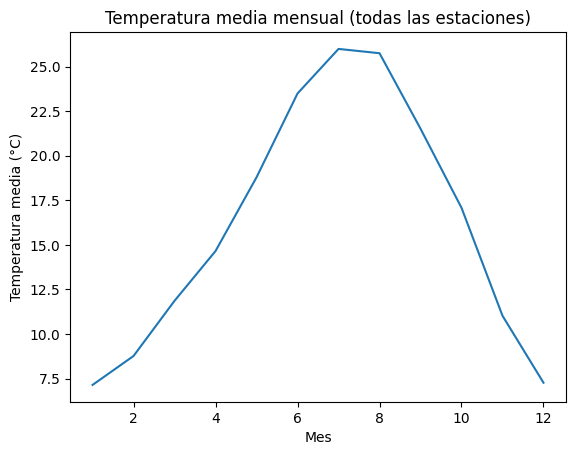

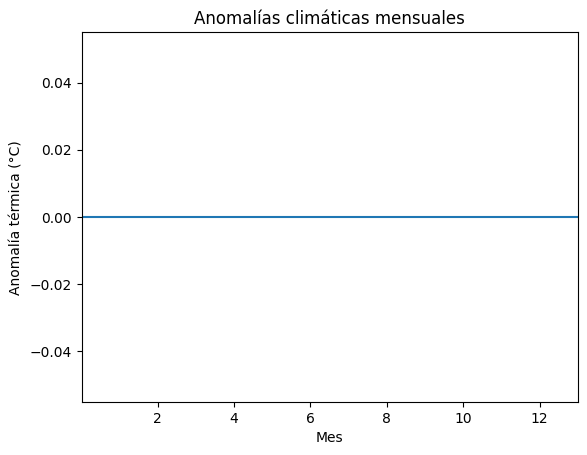

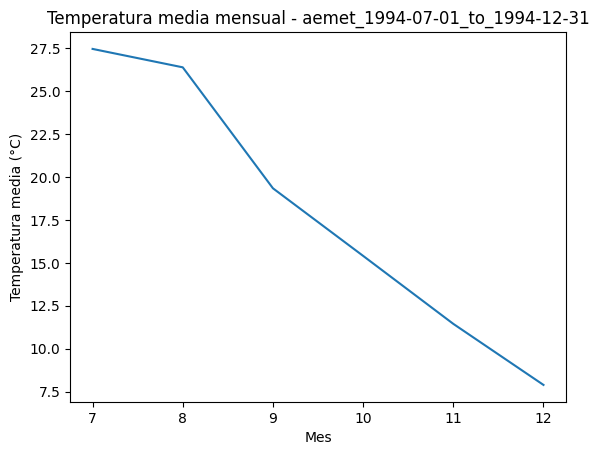

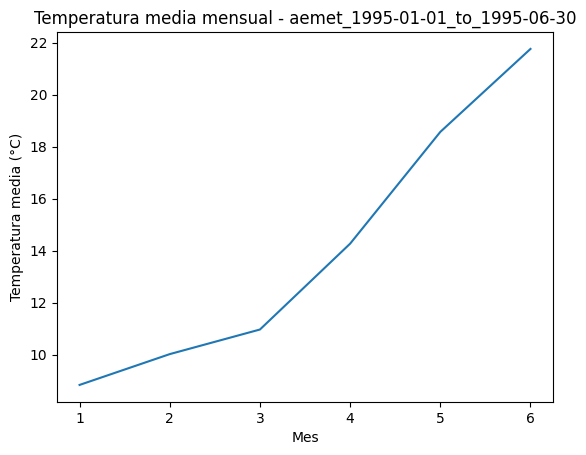

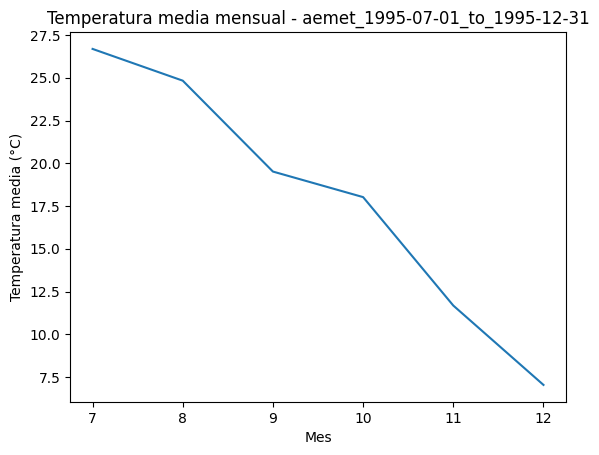

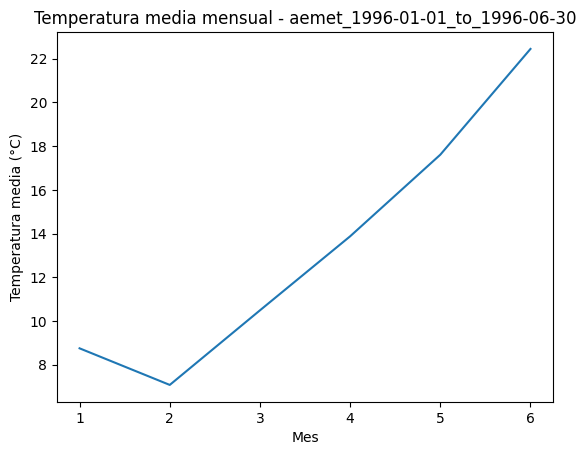

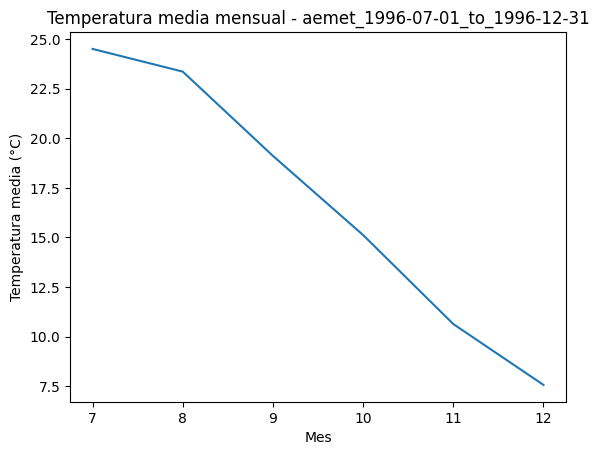

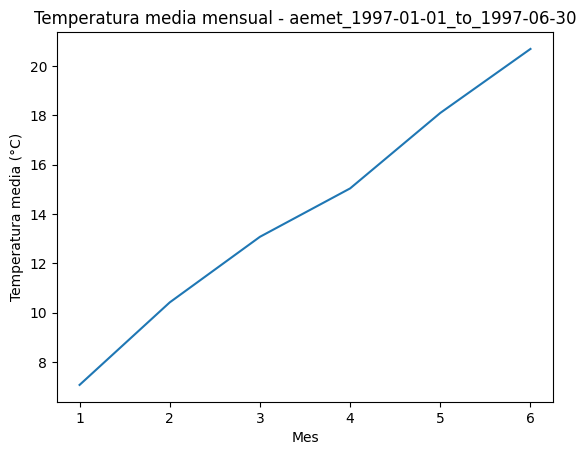

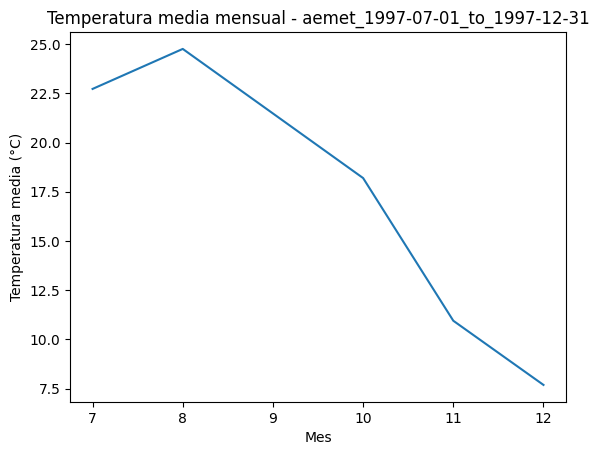

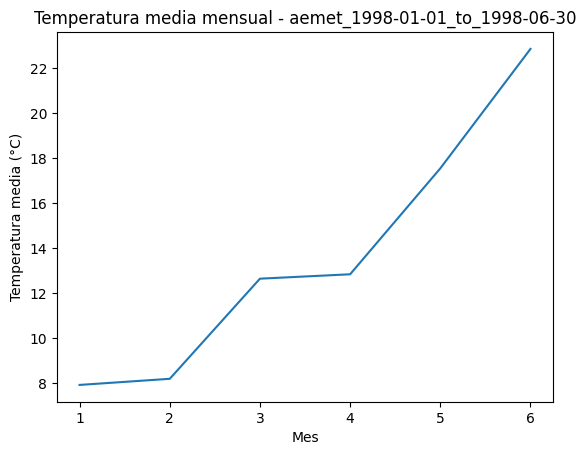

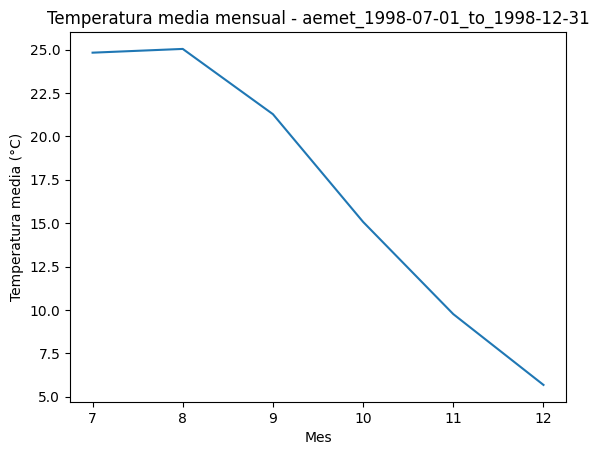

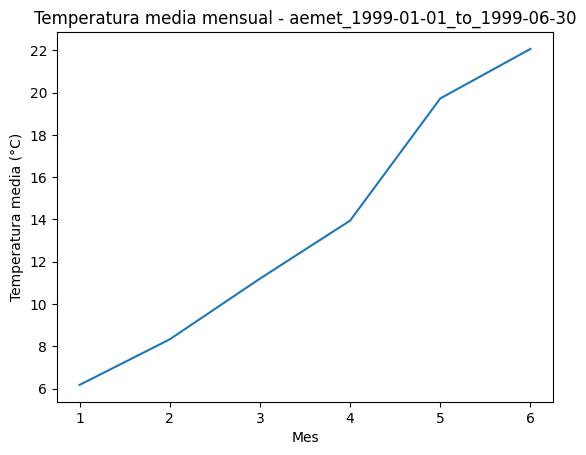

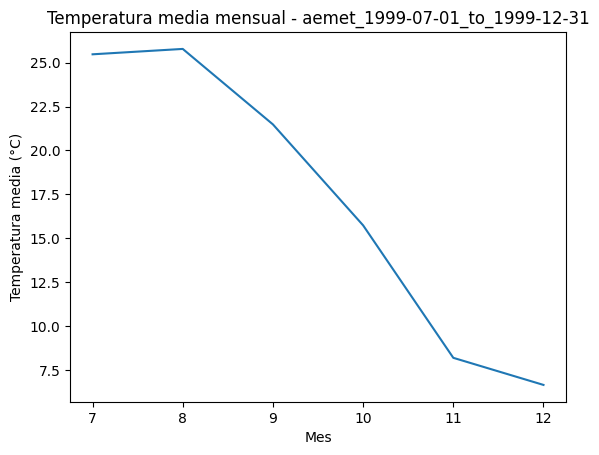

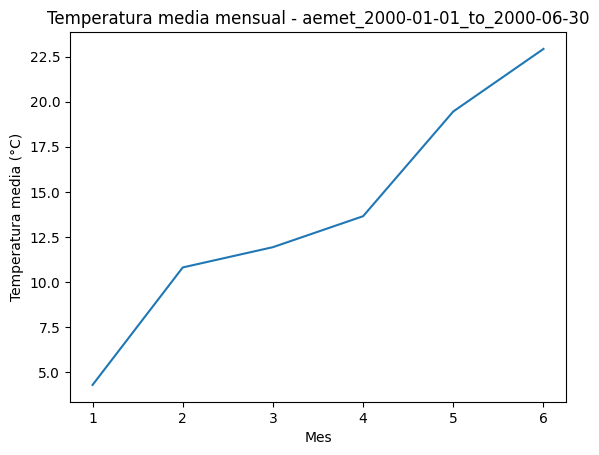

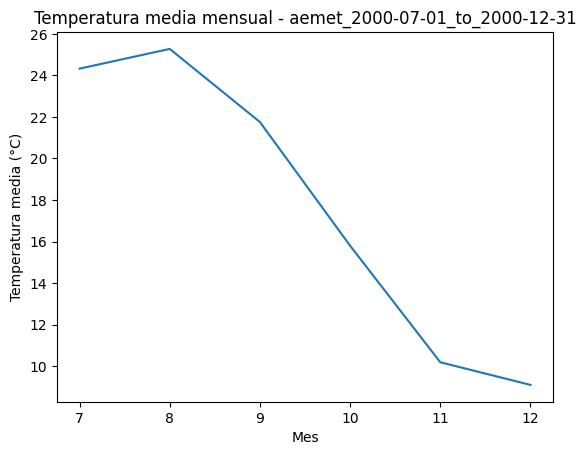

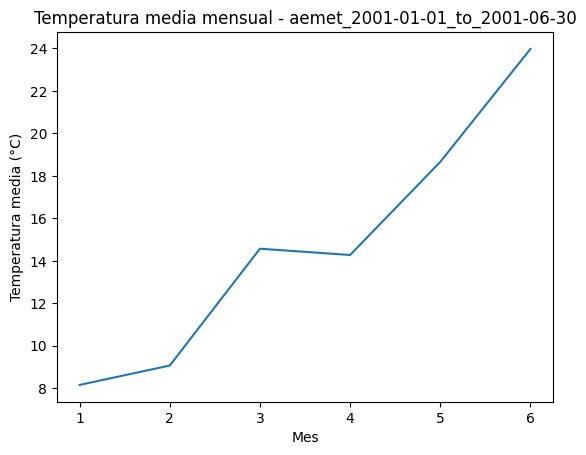

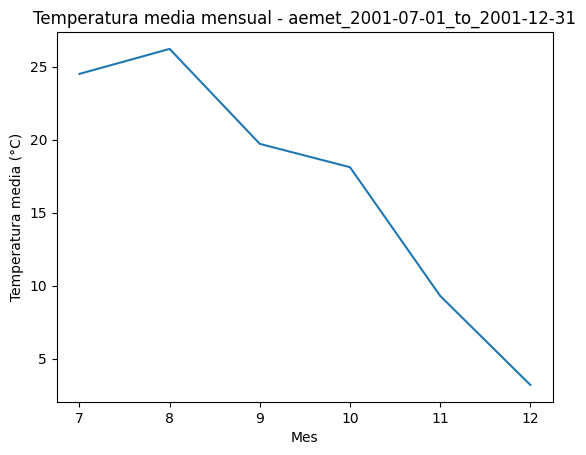

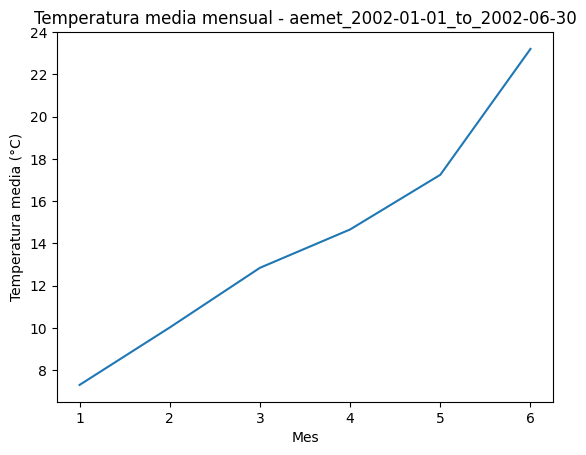

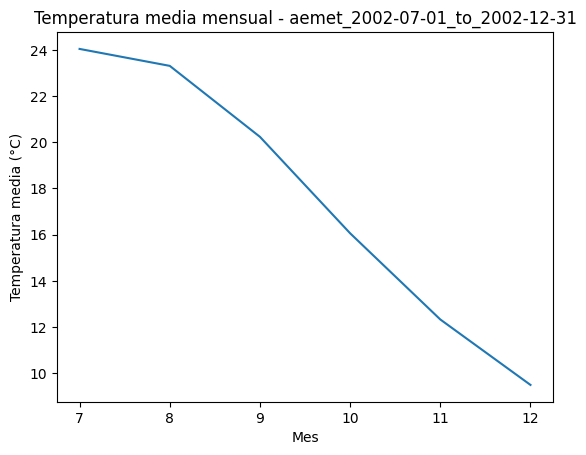

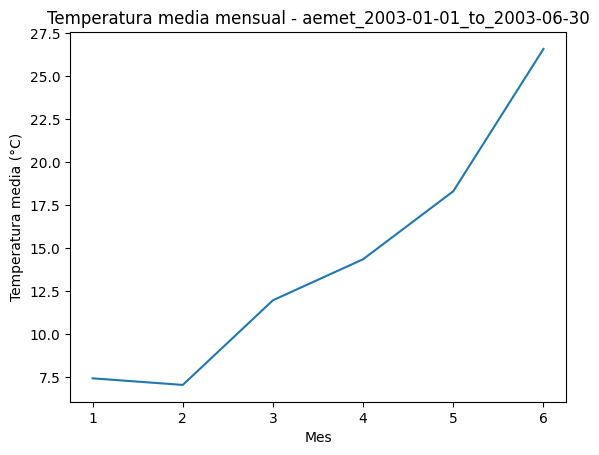

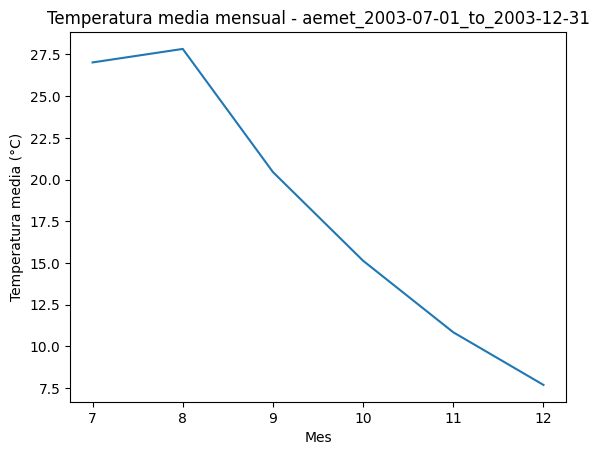

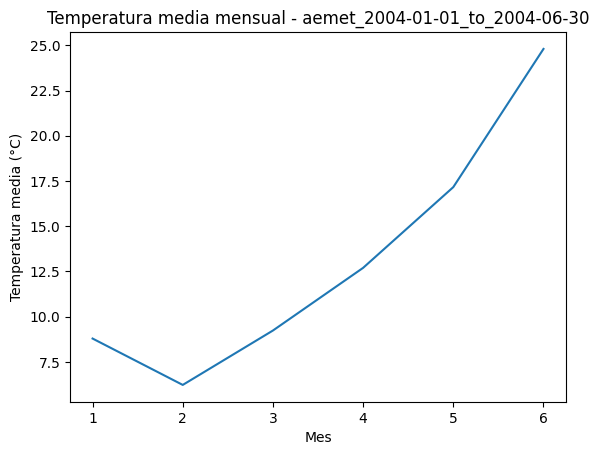

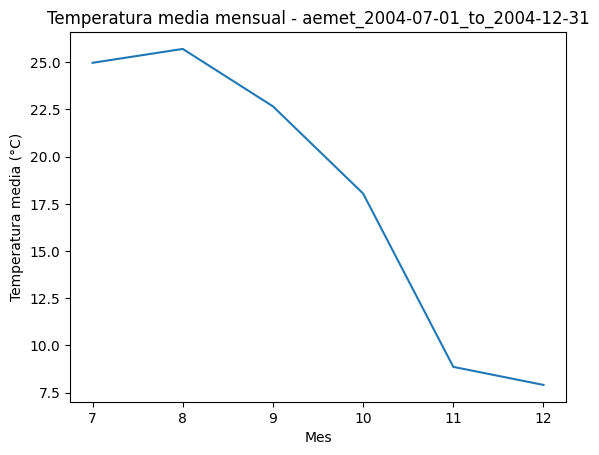

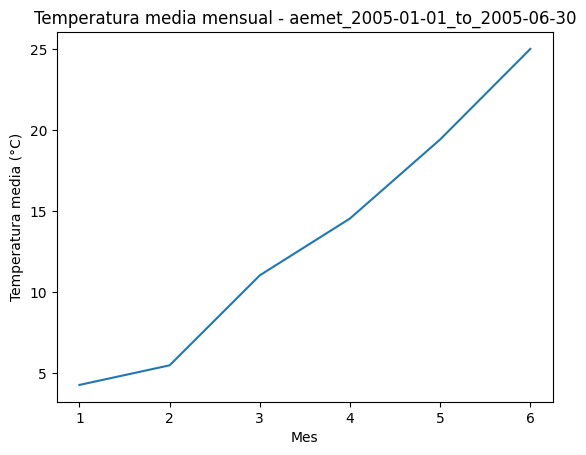

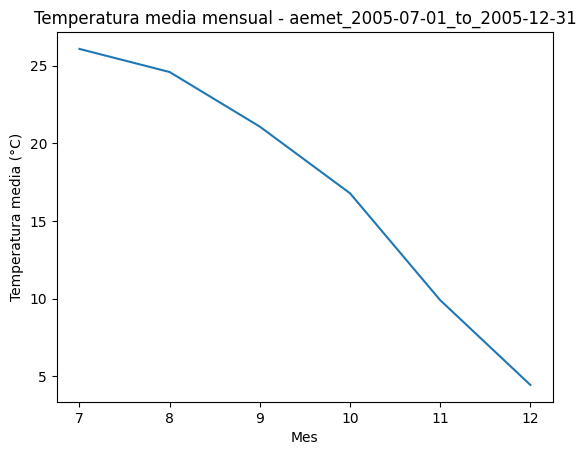

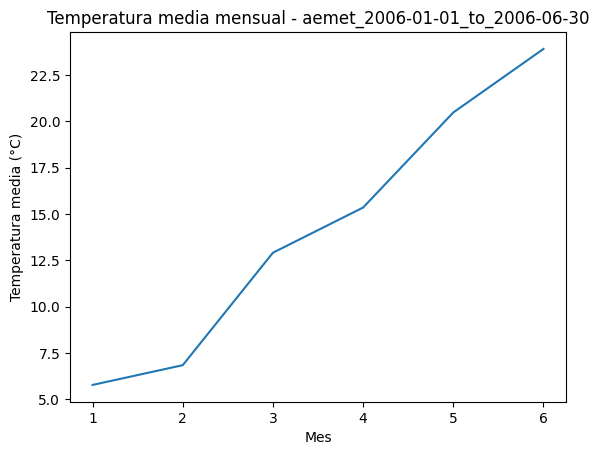

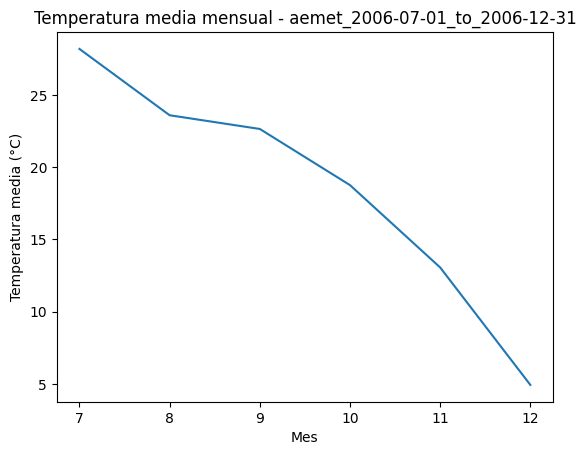

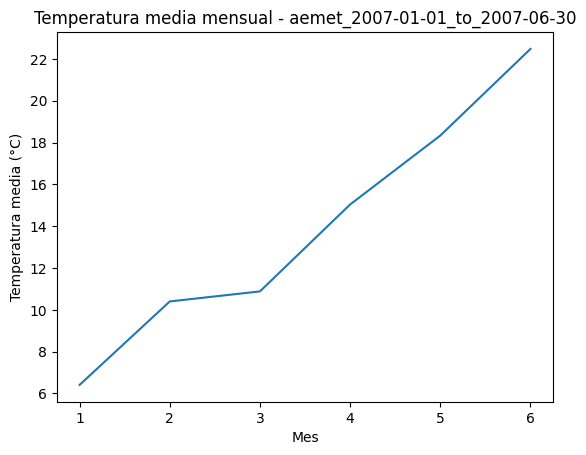

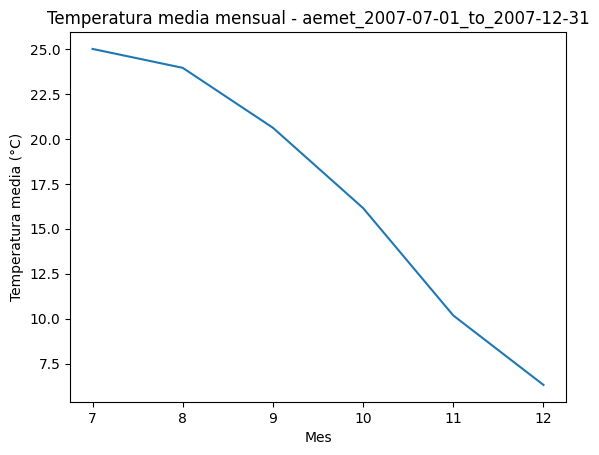

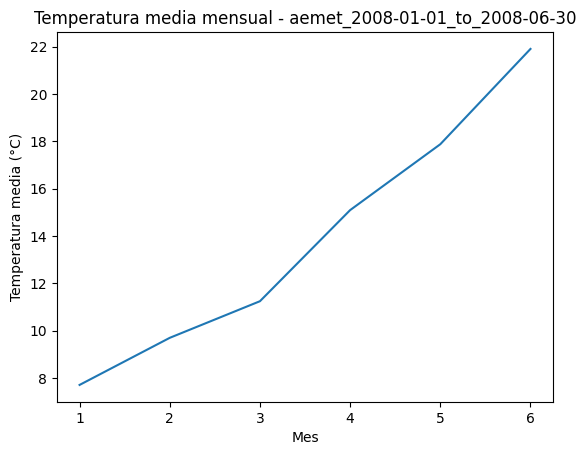

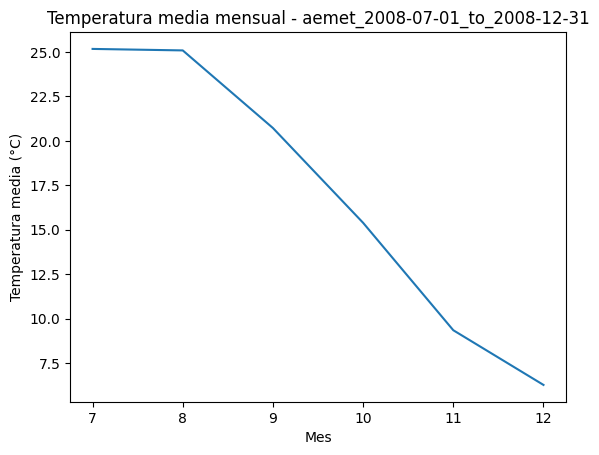

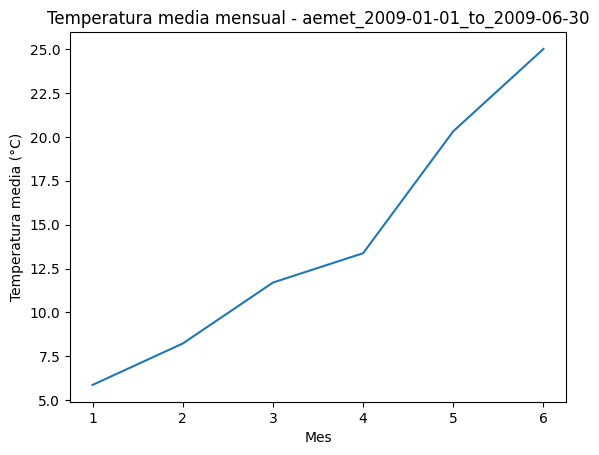

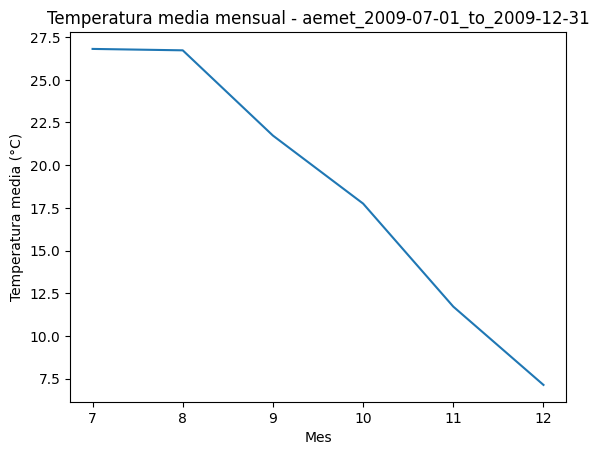

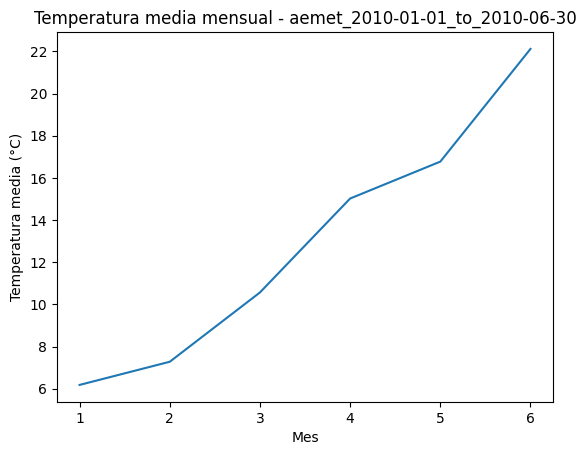

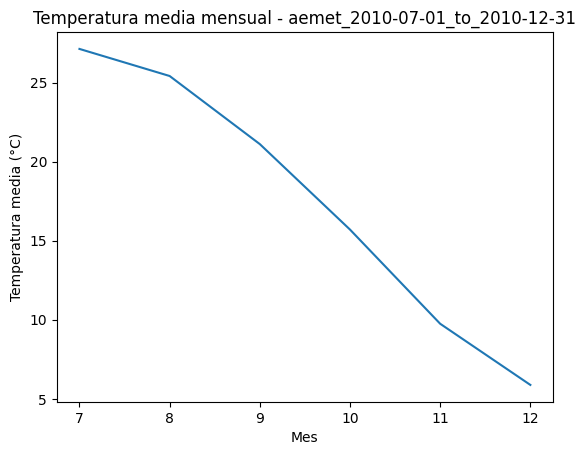

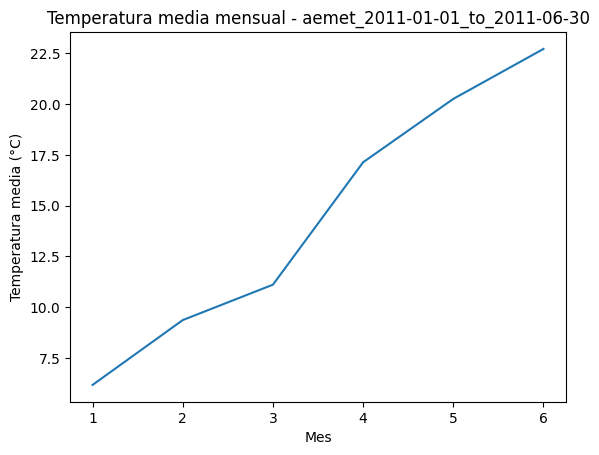

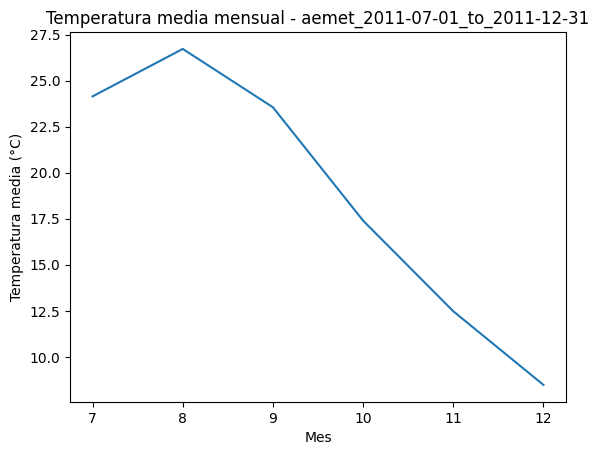

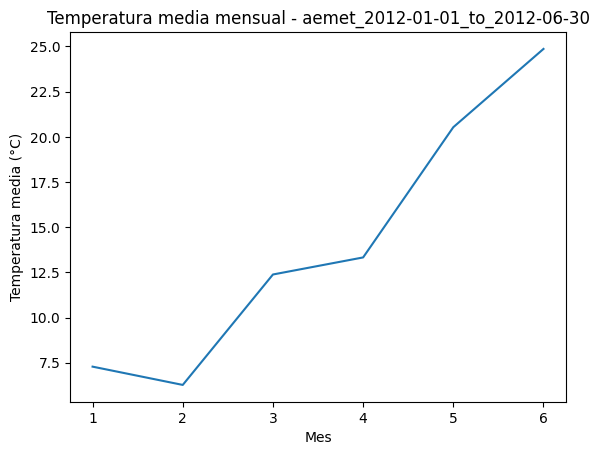

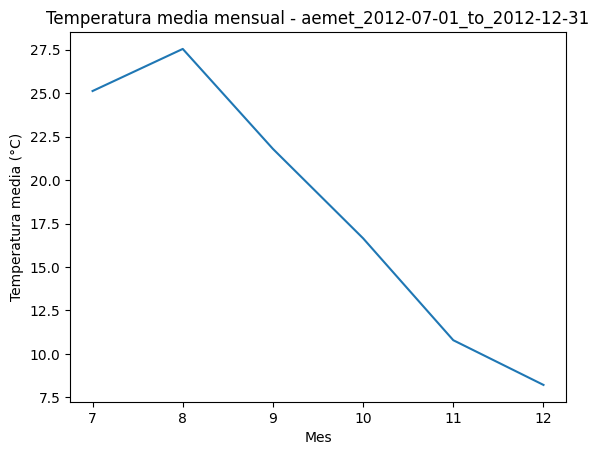

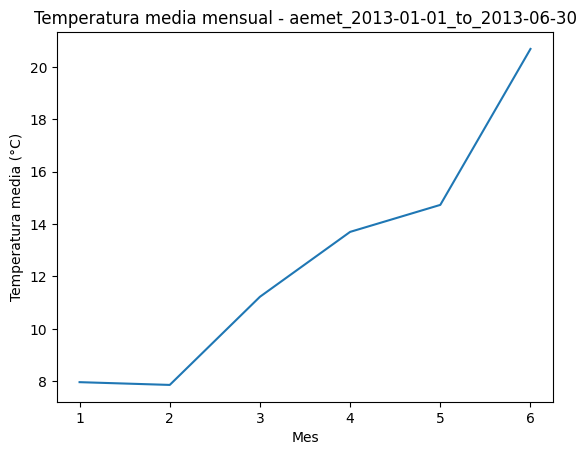

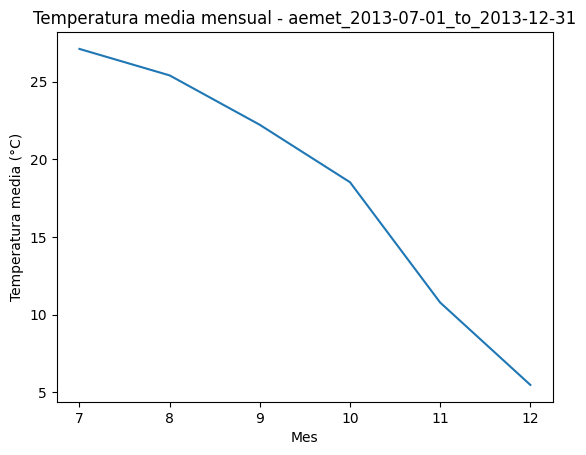

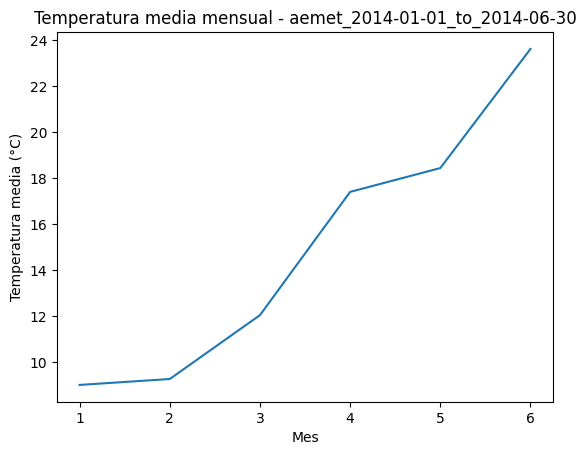

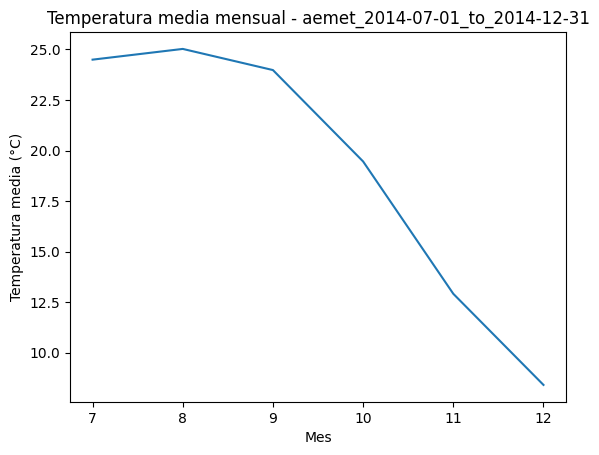

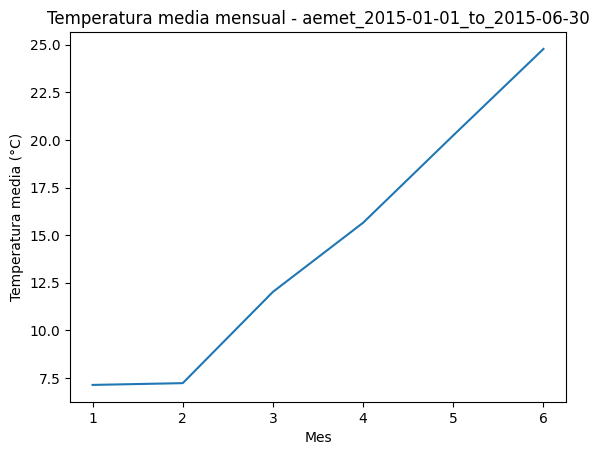

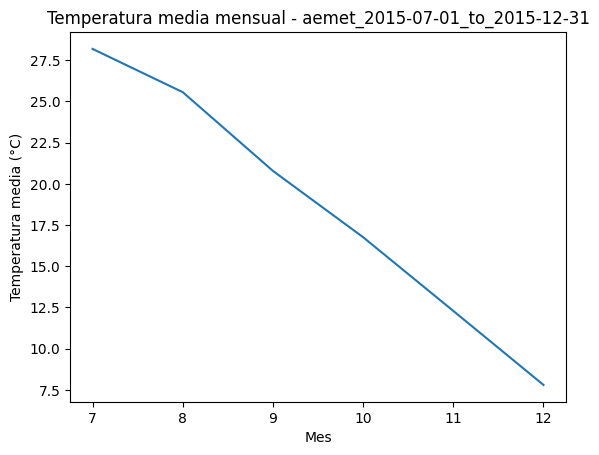

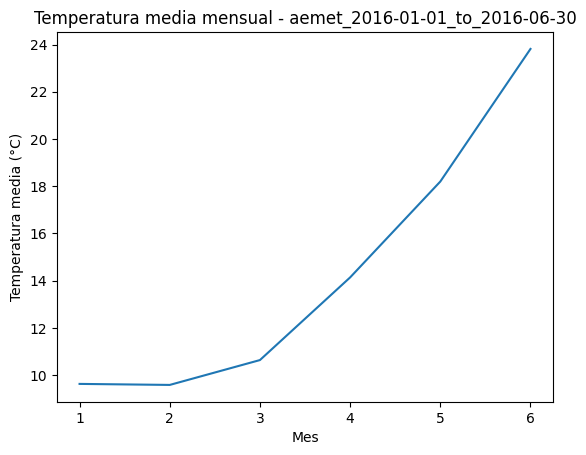

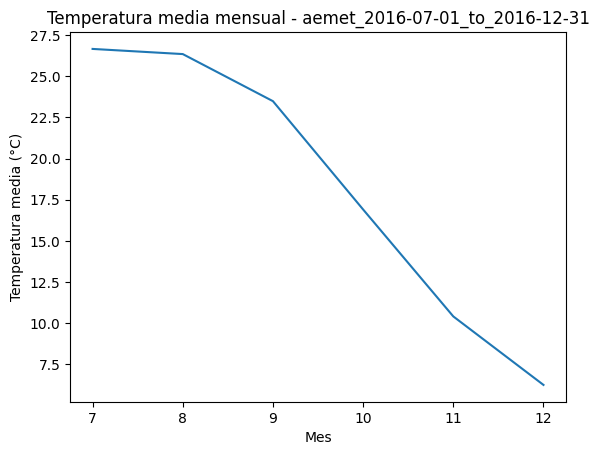

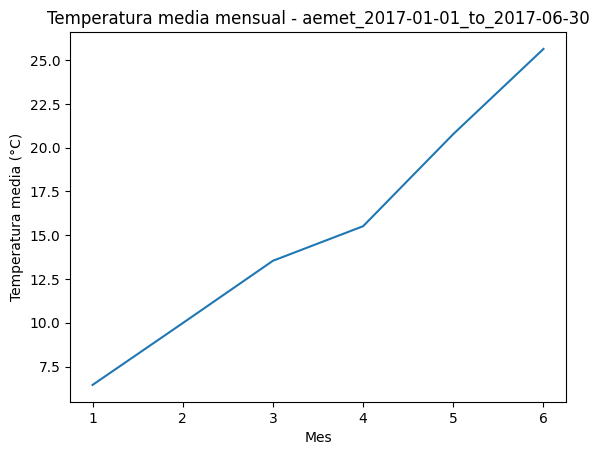

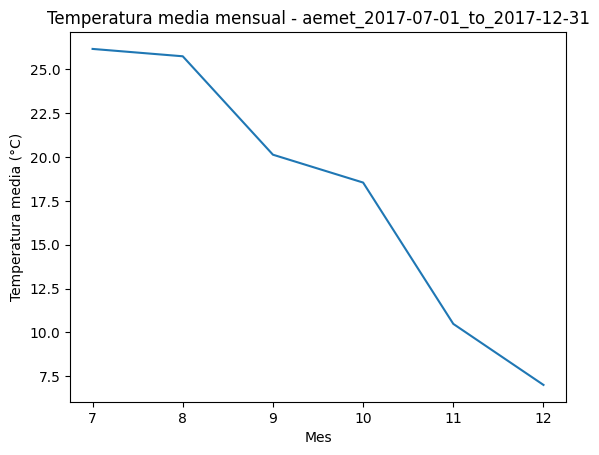

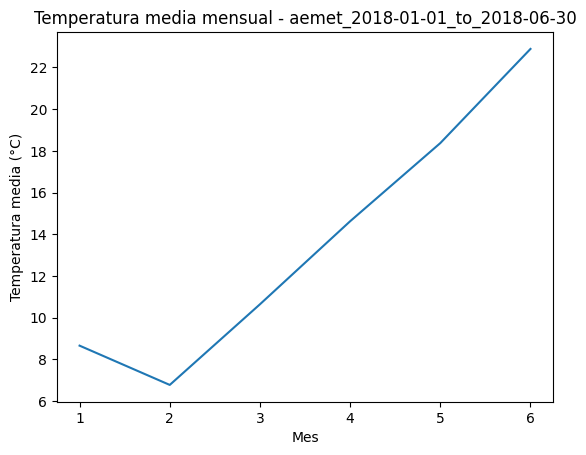

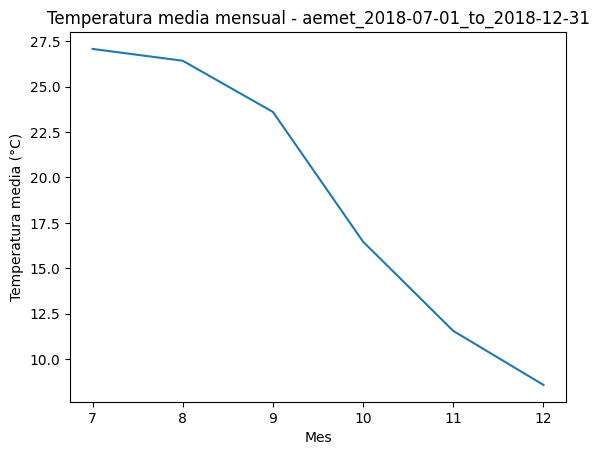

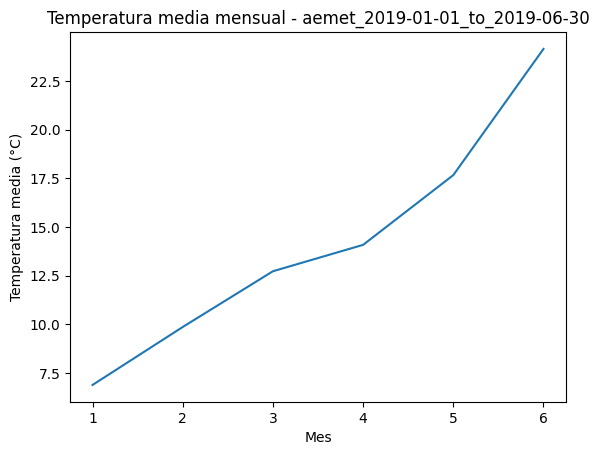

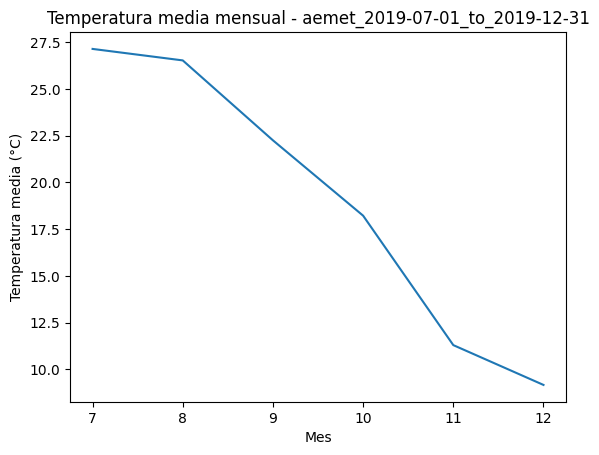

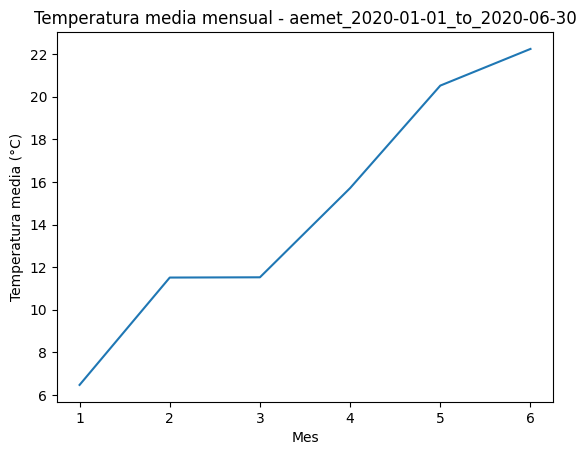

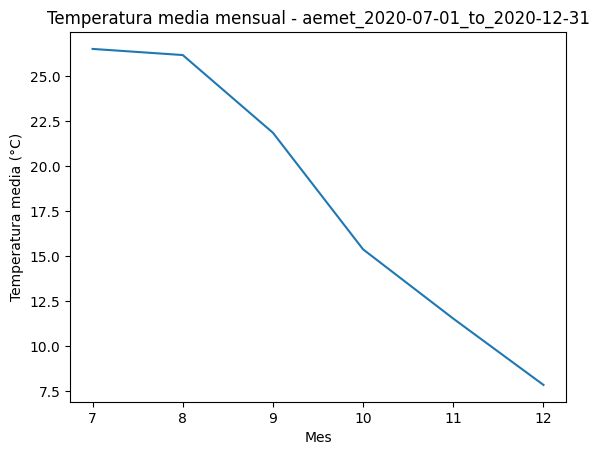

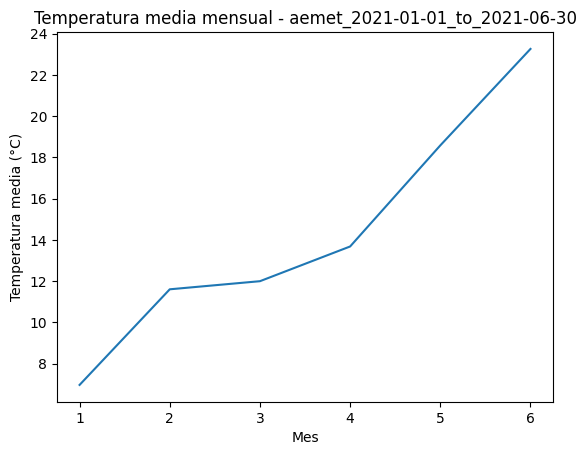

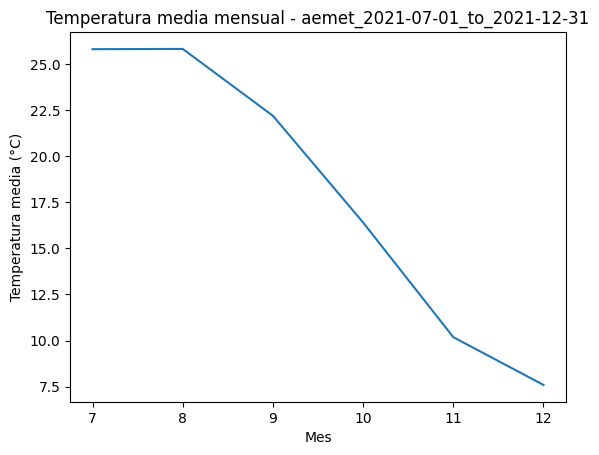

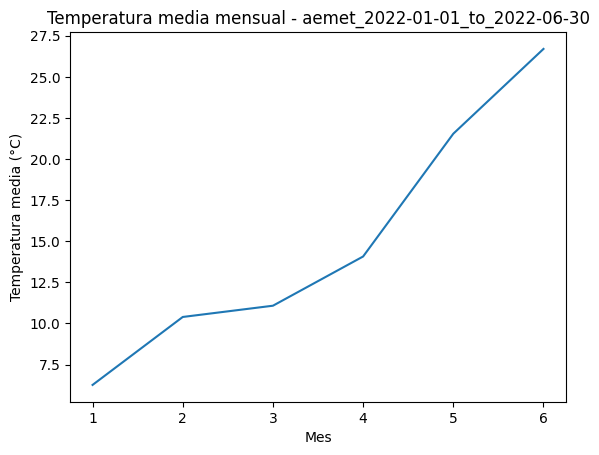

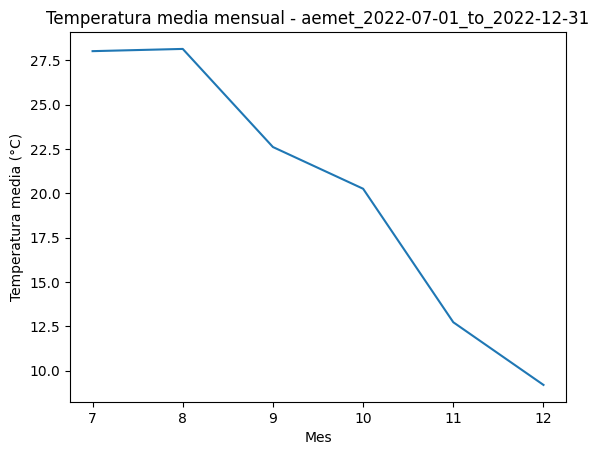

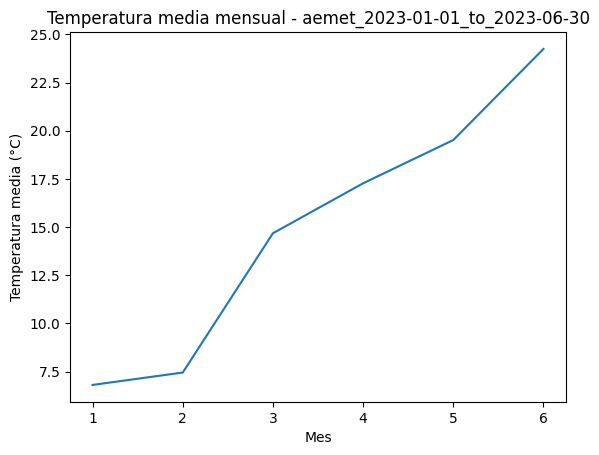

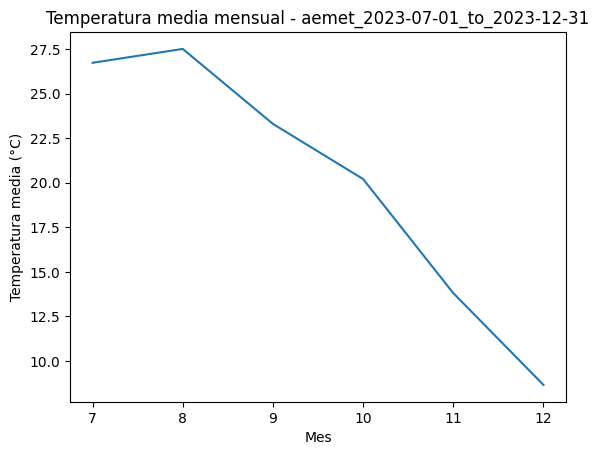

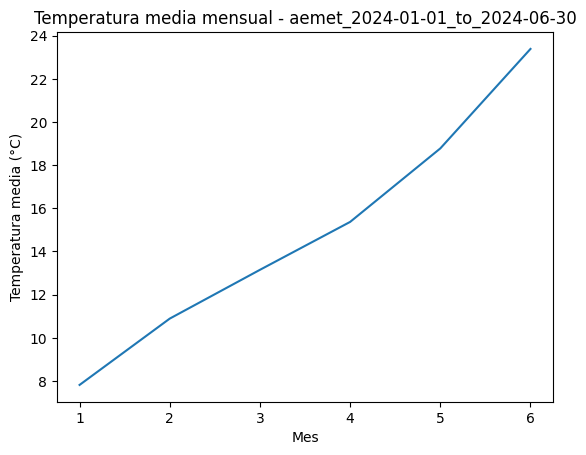

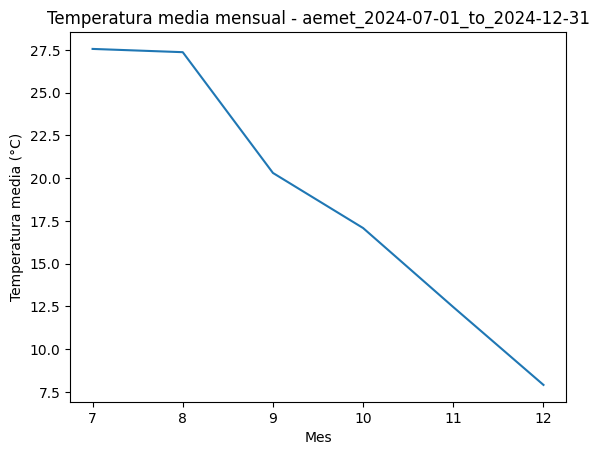

ModuleNotFoundError: No module named 'xlsxwriter'

In [ ]:
import os
import glob
import json
import zipfile
import pandas as pd
import matplotlib.pyplot as plt

# ==============================
# 1. DESCOMPRIMIR ZIP
# ==============================
zip_path = "/content/CLIMA.zip"
extract_path = "/content/CLIMA"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

# ==============================
# 2. BUSCAR JSON
# ==============================
files = glob.glob(os.path.join(extract_path, "**", "*.json"), recursive=True)

if len(files) == 0:
    raise ValueError("❌ No se encontraron archivos JSON en el ZIP")

# ==============================
# 3. FUNCIÓN LECTURA AEMET
# ==============================
def read_aemet(file):
    try:
        with open(file, encoding="utf-8") as f:
            data = json.load(f)

        # Caso 1: lista directa
        if isinstance(data, list):
            df = pd.DataFrame(data)

        # Caso 2: diccionario con clave "datos"
        elif isinstance(data, dict) and "datos" in data:
            df = pd.DataFrame(data["datos"])

        else:
            return None

        required_cols = ["fecha", "tmax", "tmin"]
        if not all(col in df.columns for col in required_cols):
            return None

        df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
        df["estacion"] = os.path.basename(file).replace(".json", "")

        for col in ["prec", "velmedia", "hrMedia"]:
            if col not in df.columns:
                df[col] = None

        df = df[["fecha", "estacion", "tmax", "tmin", "prec", "velmedia", "hrMedia"]]

        return df

    except Exception as e:
        print(f"⚠️ Error leyendo {file}: {e}")
        return None

# ==============================
# 4. UNIR TODOS LOS JSON
# ==============================
dfs = [read_aemet(f) for f in files]
dfs = [df for df in dfs if df is not None]

if len(dfs) == 0:
    raise ValueError("❌ Ningún fichero JSON válido")

aemet_data = pd.concat(dfs, ignore_index=True)

# ==============================
# 5. LIMPIEZA DE DATOS
# ==============================
aemet_data = aemet_data.iloc[:-3]

num_cols = ["tmax", "tmin", "prec", "velmedia", "hrMedia"]

for col in num_cols:
    aemet_data[col] = (
        aemet_data[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
    )
    aemet_data[col] = pd.to_numeric(aemet_data[col], errors="coerce")

aemet_data["año"] = aemet_data["fecha"].dt.year
aemet_data["mes"] = aemet_data["fecha"].dt.month
aemet_data["tmedia"] = (aemet_data["tmax"] + aemet_data["tmin"]) / 2

# ==============================
# 6. TABLAS CLIMÁTICAS
# ==============================
mensual = (
    aemet_data
    .groupby(["estacion", "año", "mes"], as_index=False)
    .mean(numeric_only=True)
)

media_global = (
    mensual
    .groupby("mes", as_index=False)
    .mean(numeric_only=True)
)

climatologia = media_global.rename(
    columns={"tmedia": "tmedia_clima"}
)

anomalias = media_global.merge(
    climatologia[["mes", "tmedia_clima"]],
    on="mes"
)

anomalias["anomalia"] = anomalias["tmedia"] - anomalias["tmedia_clima"]

# ==============================
# 7. GRÁFICOS
# ==============================
plt.figure()
plt.plot(media_global["mes"], media_global["tmedia"])
plt.xlabel("Mes")
plt.ylabel("Temperatura media (°C)")
plt.title("Temperatura media mensual (todas las estaciones)")
plt.show()

plt.figure()
plt.bar(anomalias["mes"], anomalias["anomalia"])
plt.axhline(0)
plt.xlabel("Mes")
plt.ylabel("Anomalía térmica (°C)")
plt.title("Anomalías climáticas mensuales")
plt.show()

for est in mensual["estacion"].unique():
    df_est = mensual[mensual["estacion"] == est]

    plt.figure()
    plt.plot(df_est["mes"], df_est["tmedia"])
    plt.xlabel("Mes")
    plt.ylabel("Temperatura media (°C)")
    plt.title(f"Temperatura media mensual - {est}")
    plt.show()

# ==============================
# 8. EXPORTAR Y DESCARGAR TABLAS
# ==============================
from google.colab import files

# CSV diarios
aemet_data.to_csv("/content/aemet_diario.csv", index=False, encoding="utf-8")

# CSV mensual
mensual.to_csv("/content/climatologia_mensual.csv", index=False, encoding="utf-8")

# CSV anomalías
anomalias.to_csv("/content/anomalias_climaticas.csv", index=False, encoding="utf-8")

# Excel completo
excel_path = "/content/resultados_clima.xlsx"
with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    aemet_data.to_excel(writer, sheet_name="Diario", index=False)
    mensual.to_excel(writer, sheet_name="Mensual", index=False)
    media_global.to_excel(writer, sheet_name="Media_Global", index=False)
    anomalias.to_excel(writer, sheet_name="Anomalias", index=False)

# Descargar archivos
files.download("/content/aemet_diario.csv")
files.download("/content/climatologia_mensual.csv")
files.download("/content/anomalias_climaticas.csv")
files.download(excel_path)



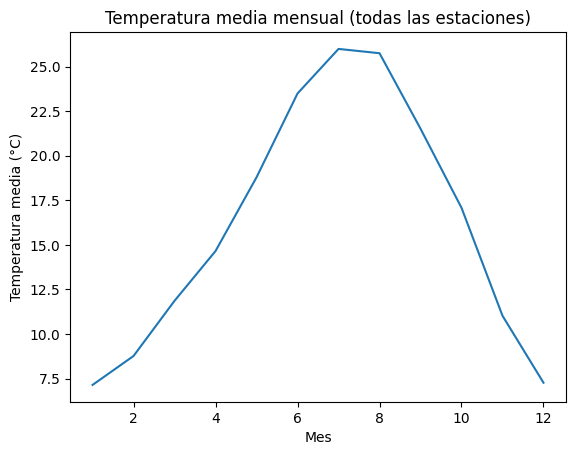

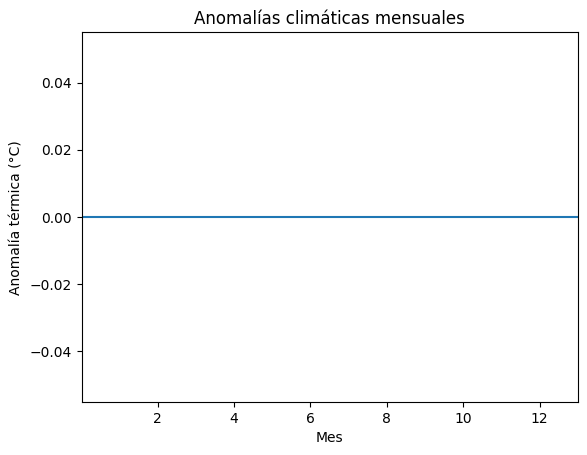

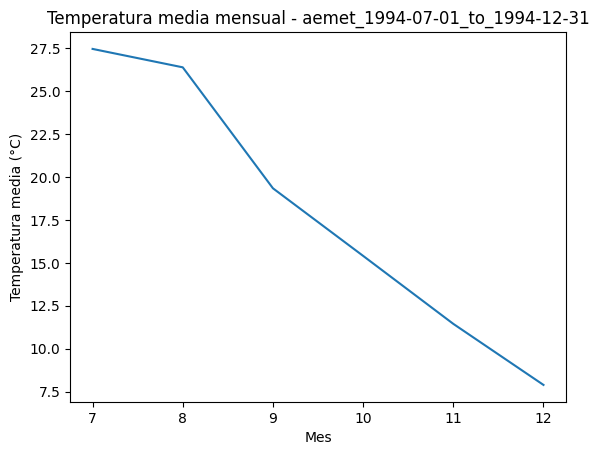

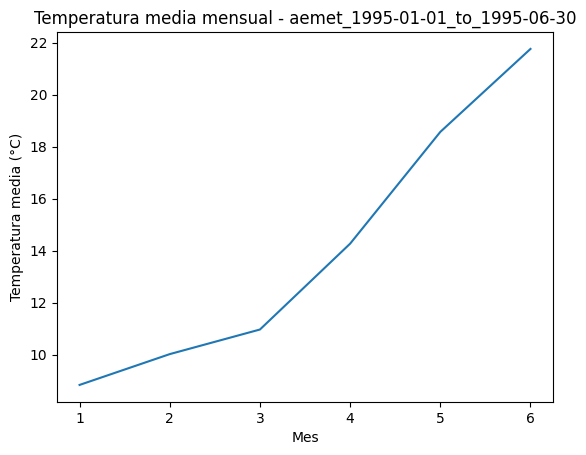

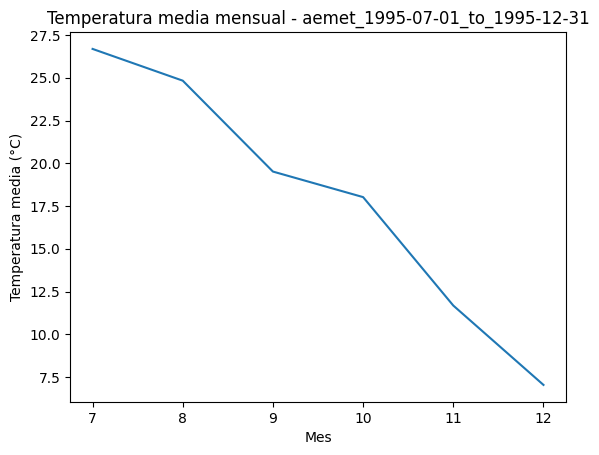

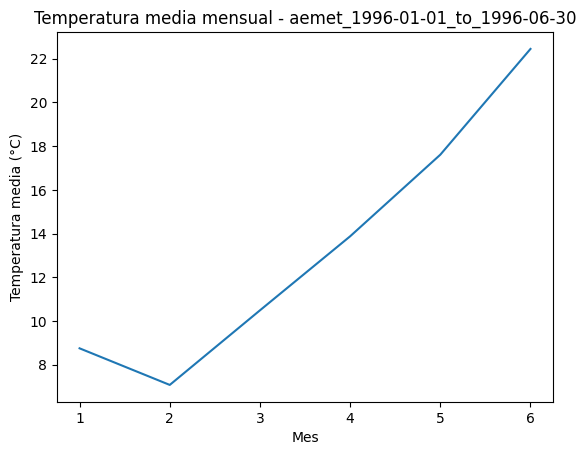

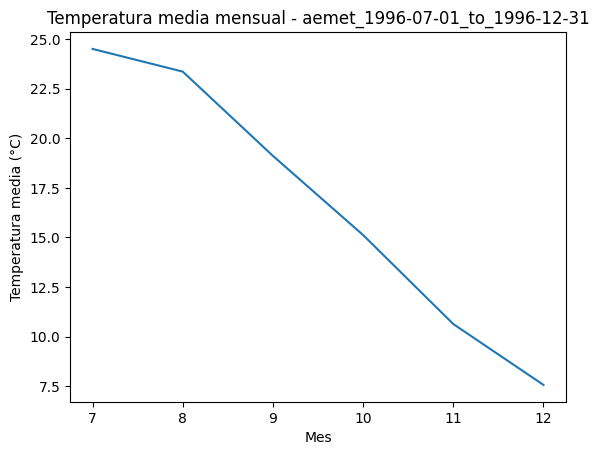

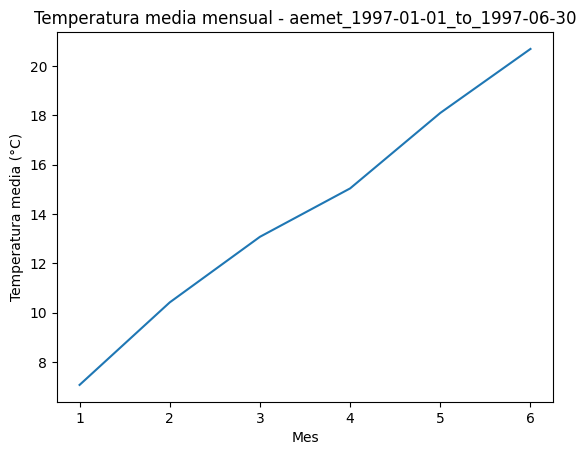

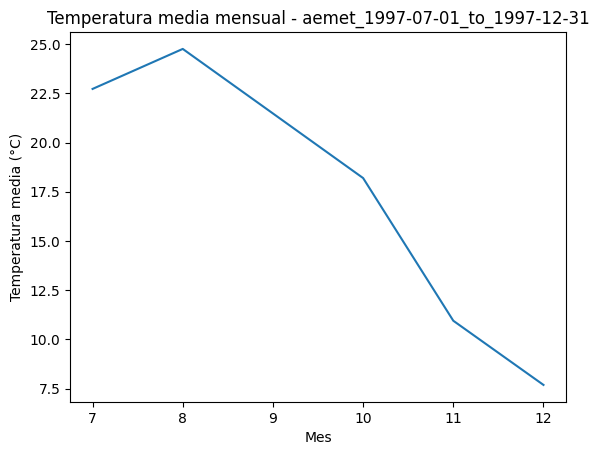

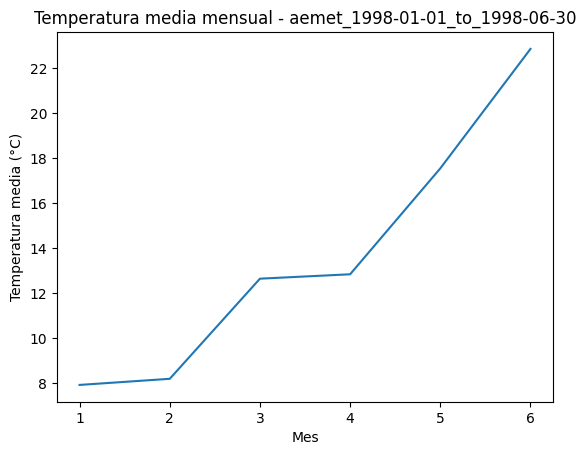

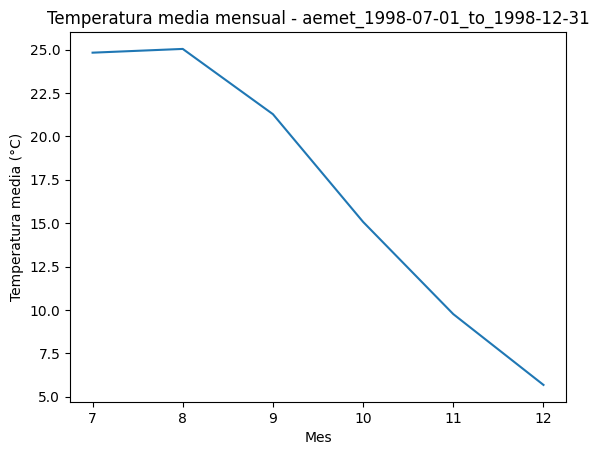

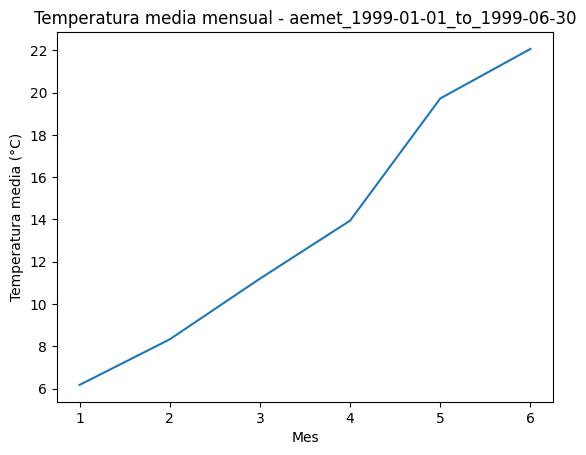

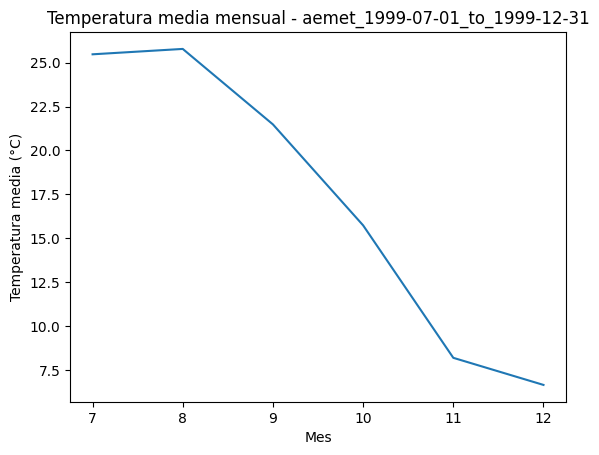

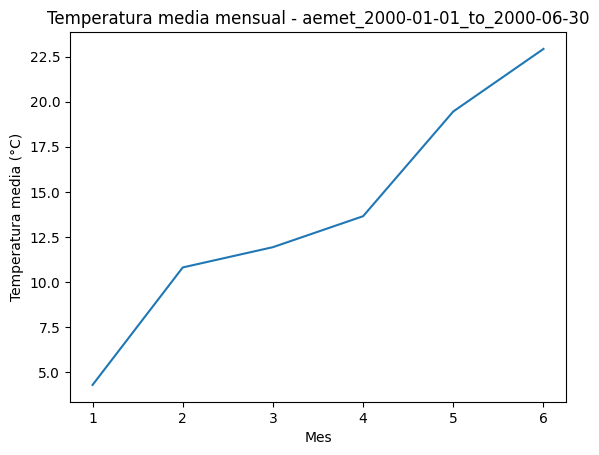

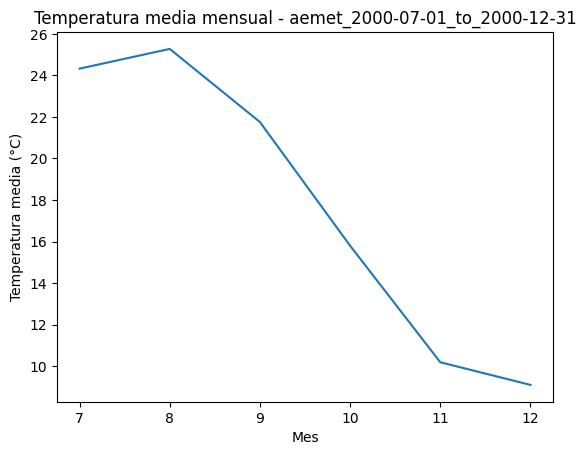

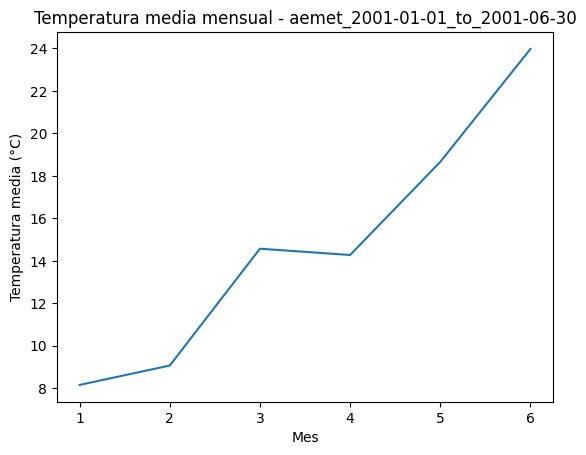

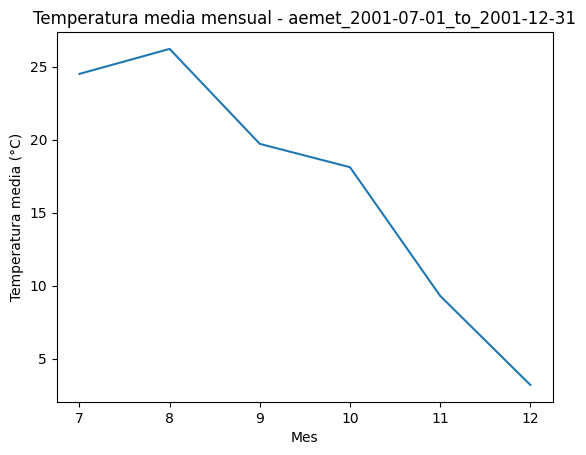

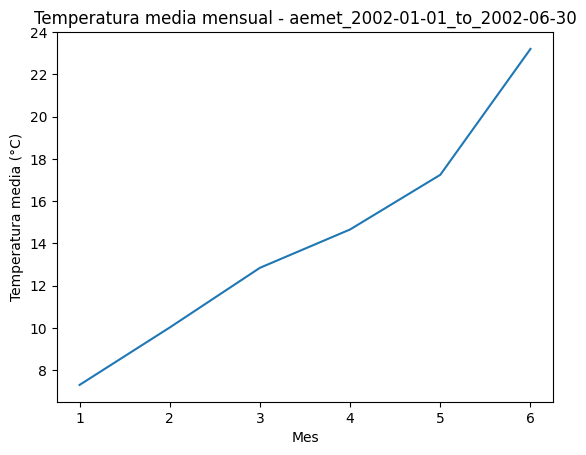

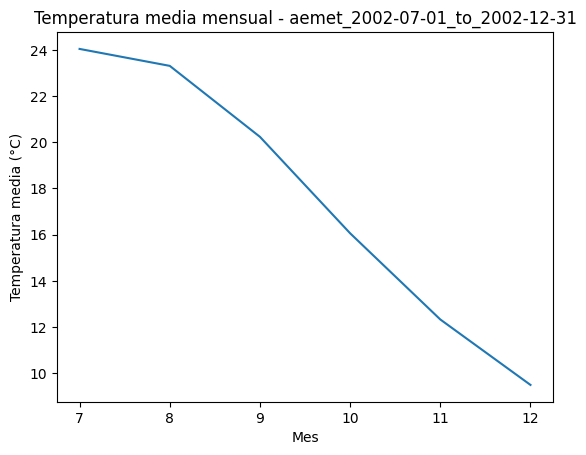

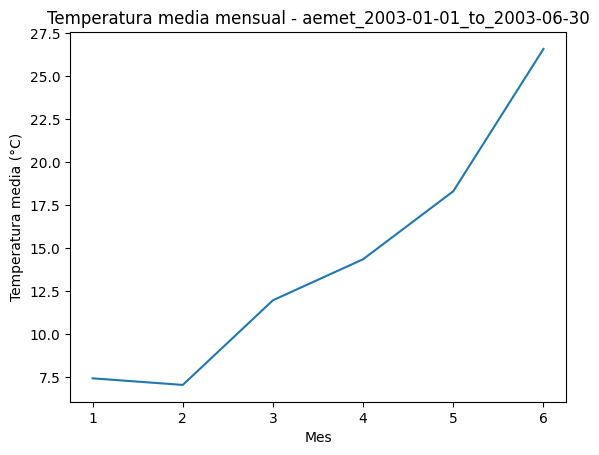

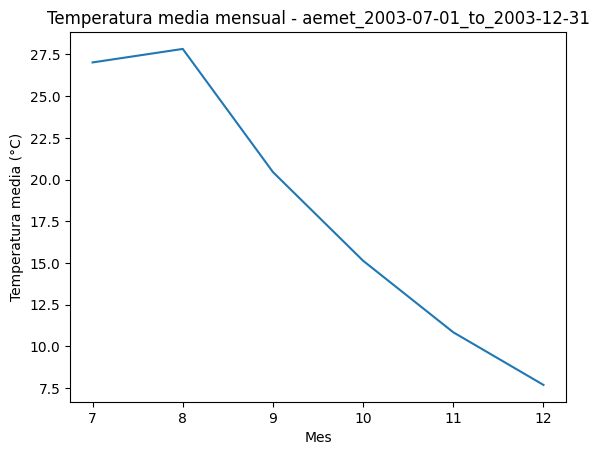

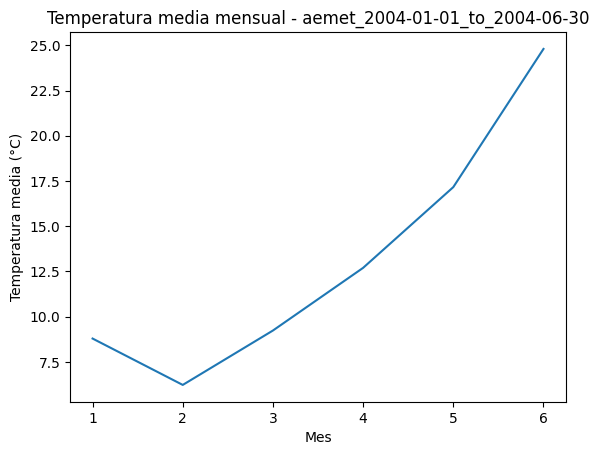

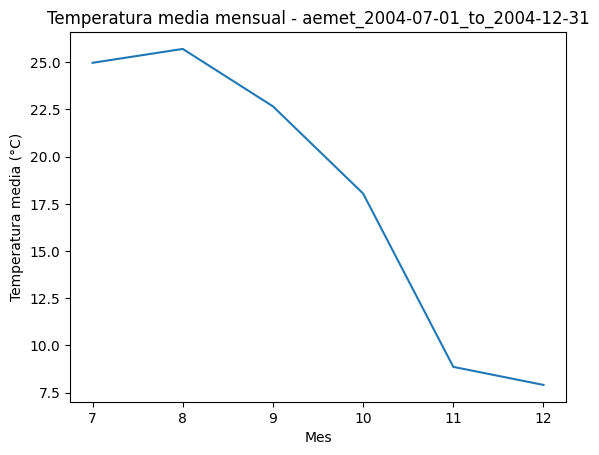

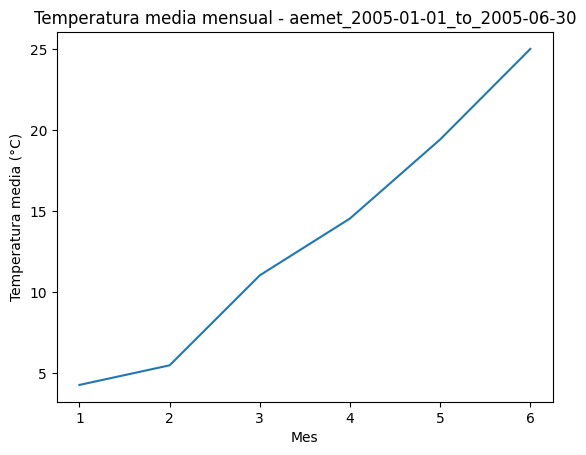

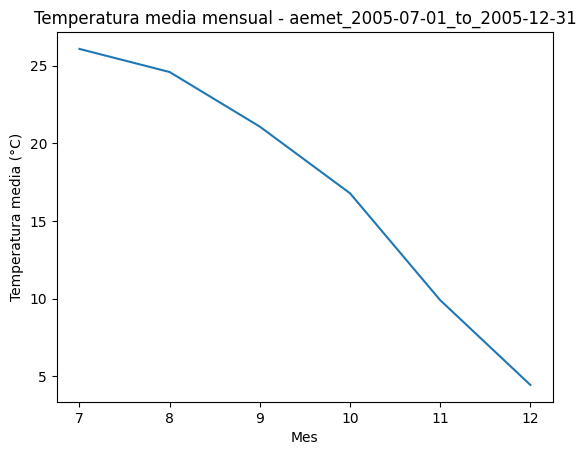

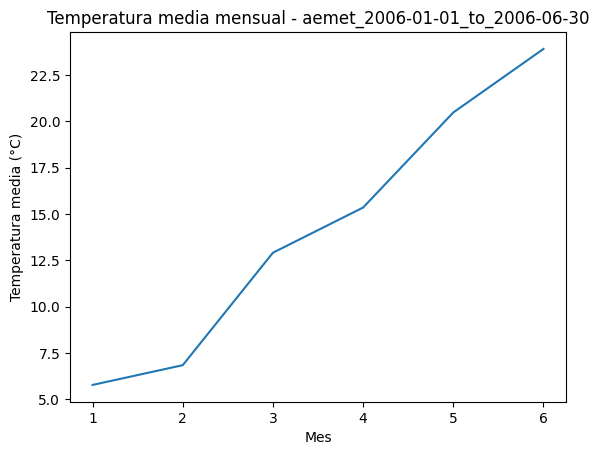

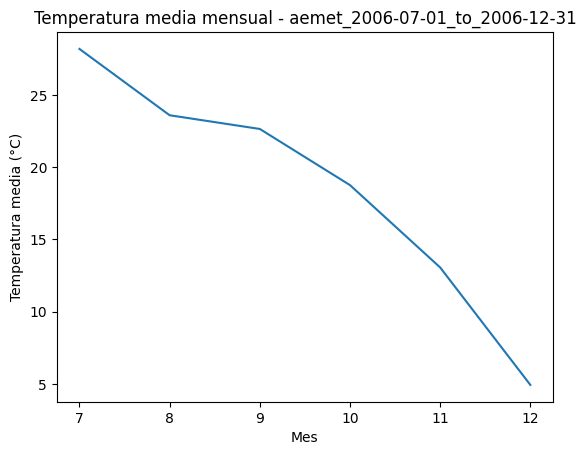

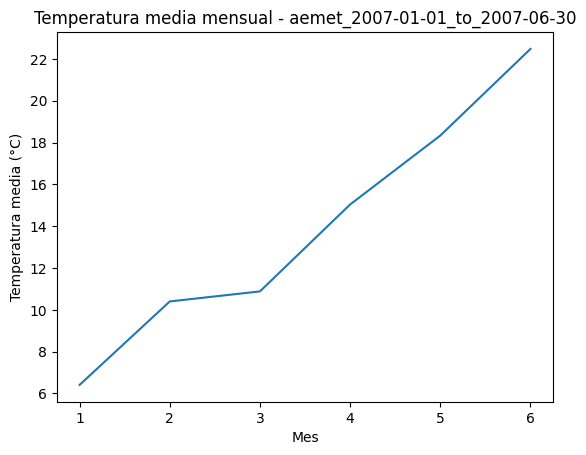

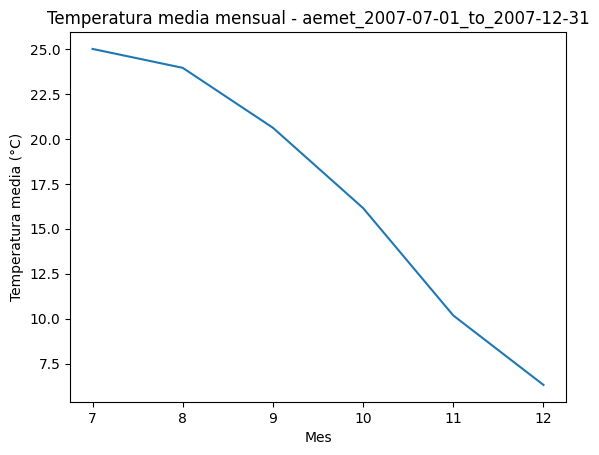

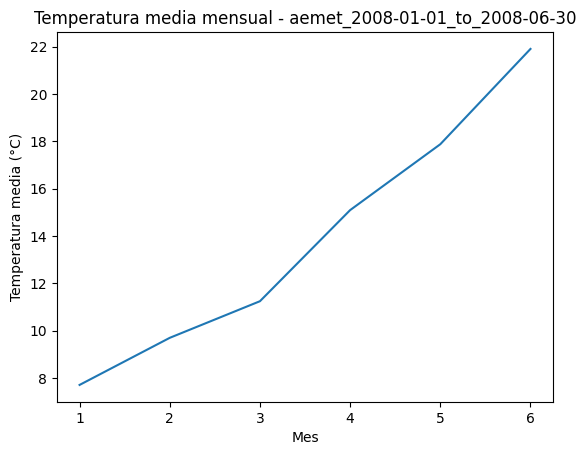

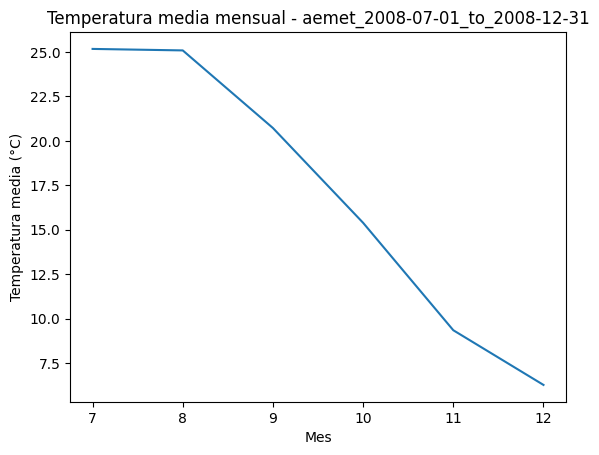

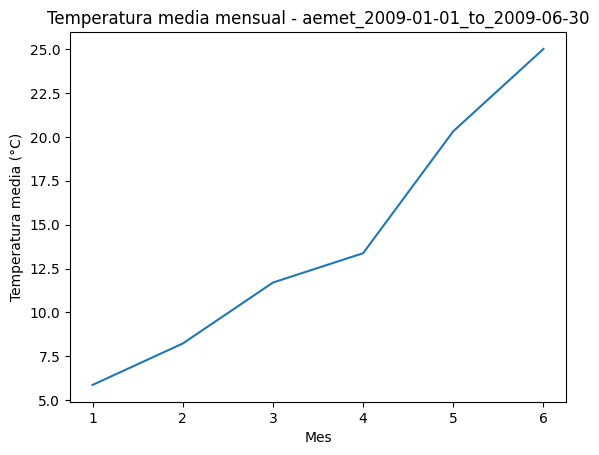

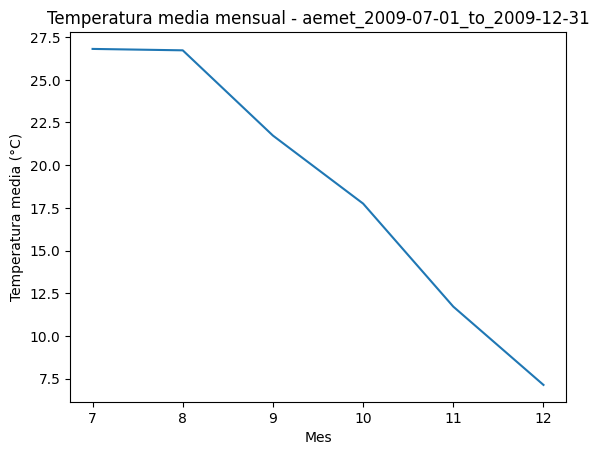

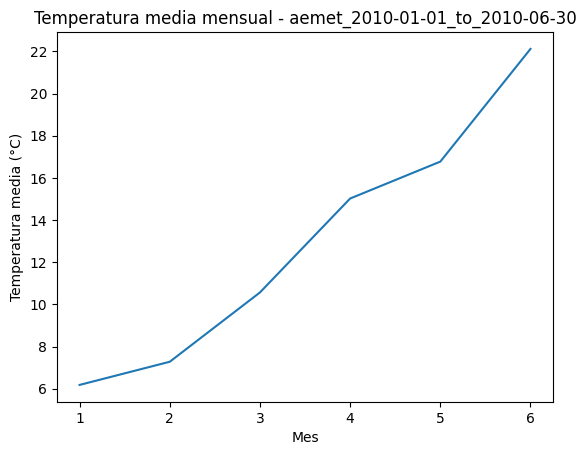

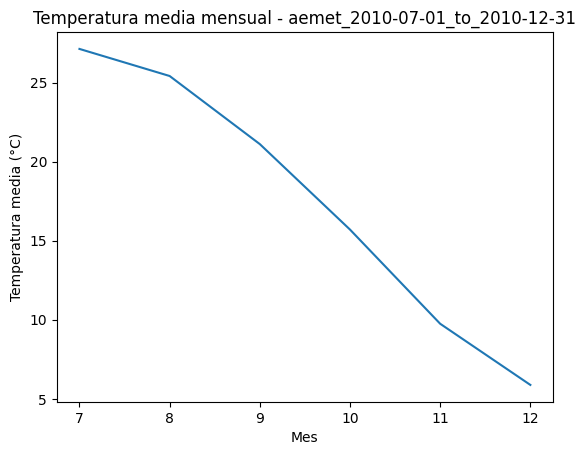

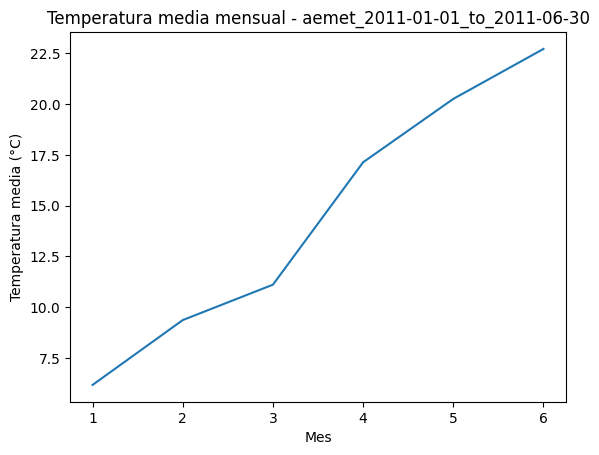

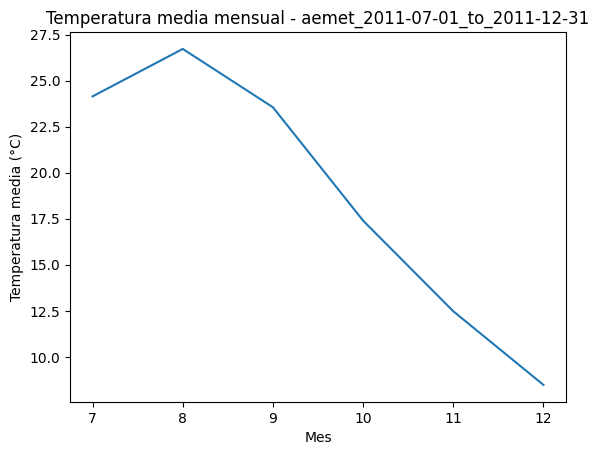

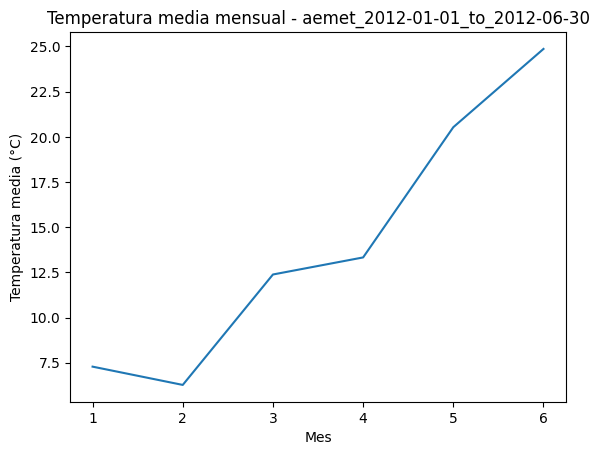

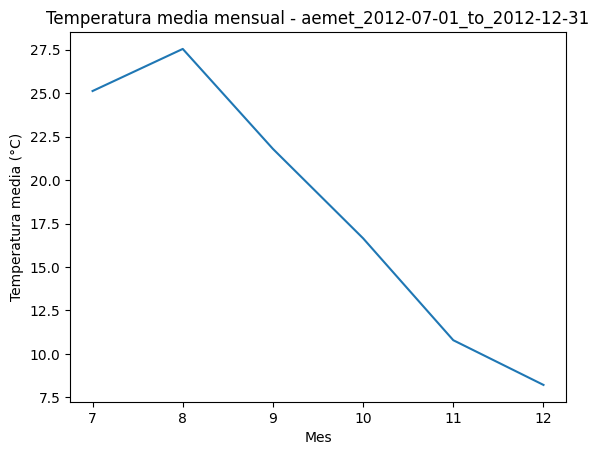

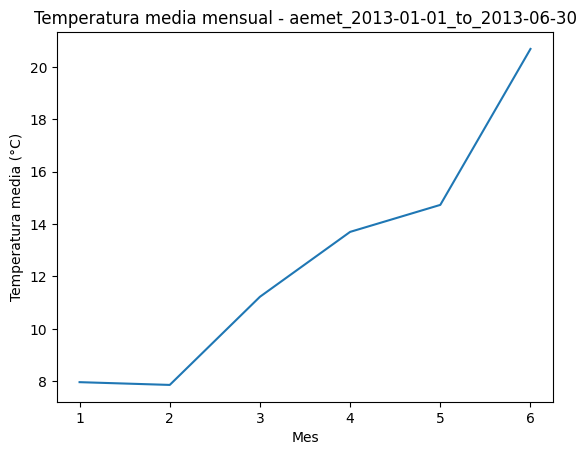

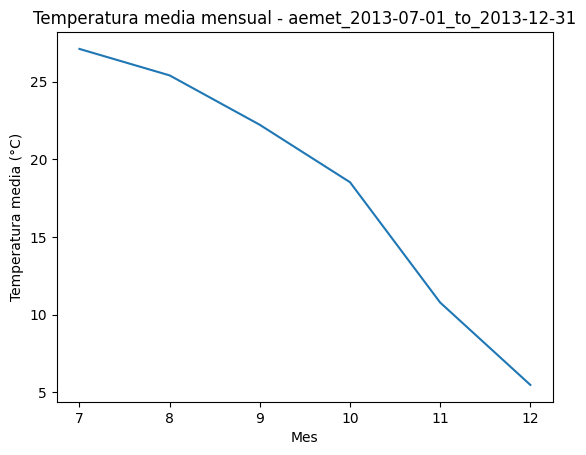

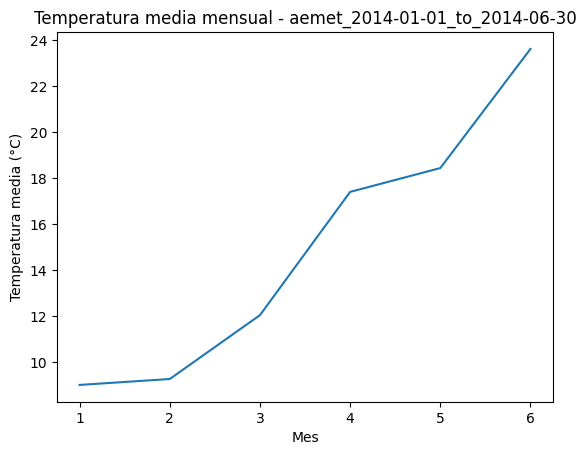

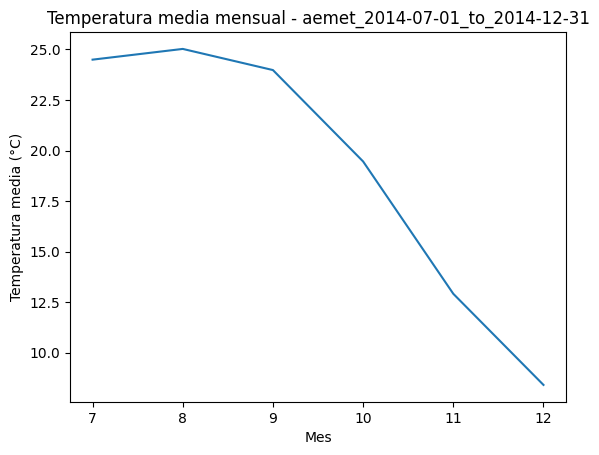

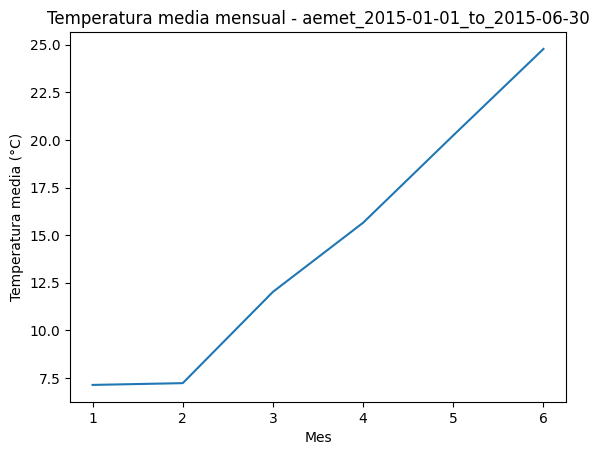

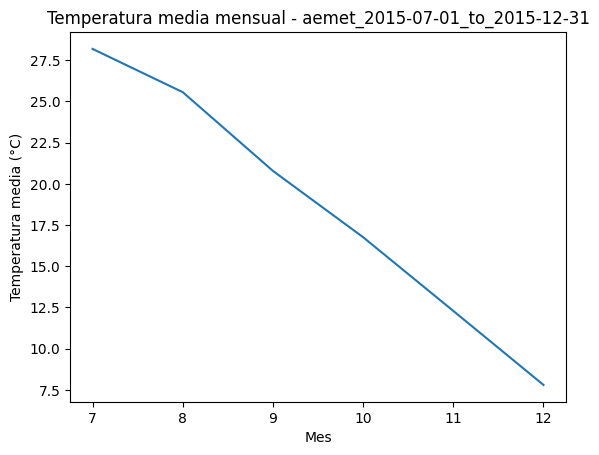

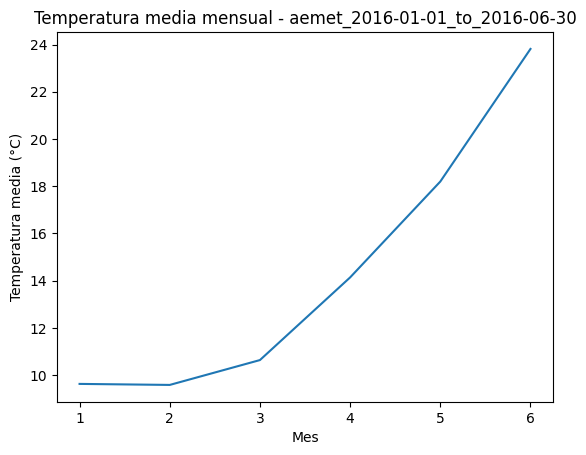

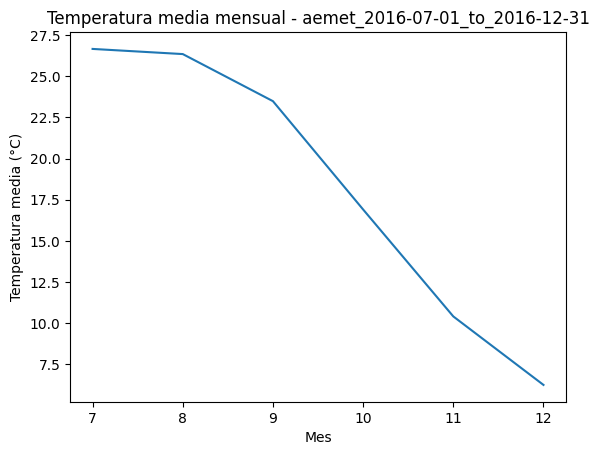

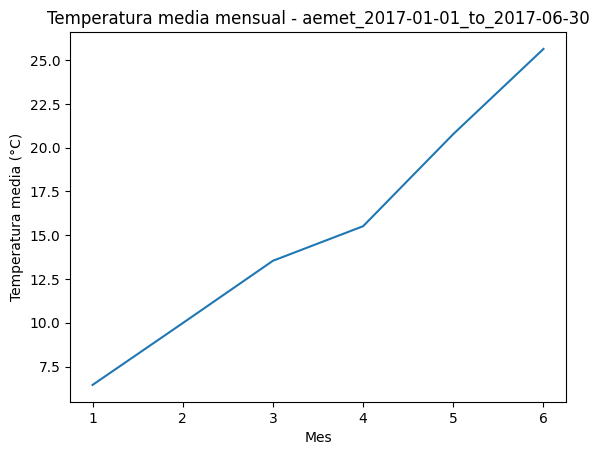

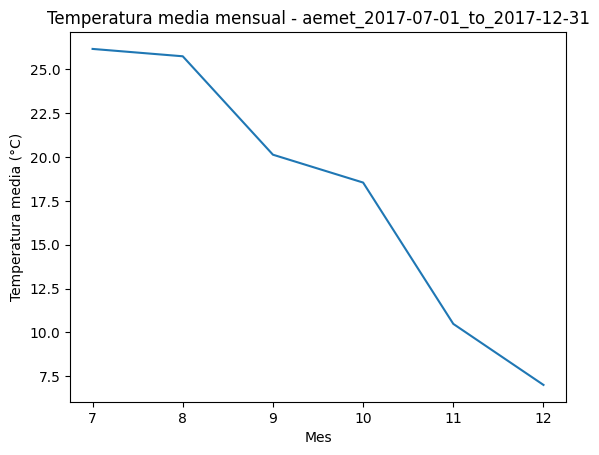

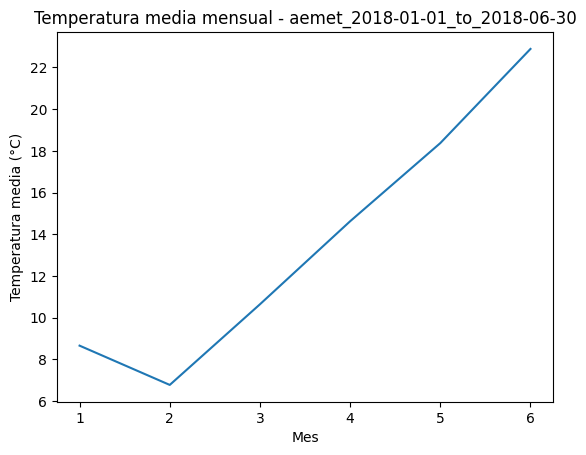

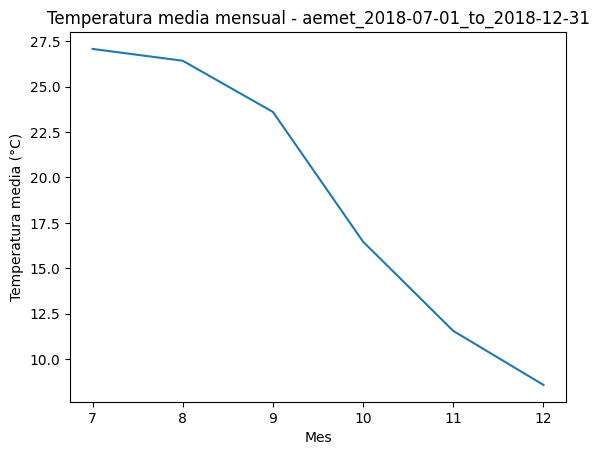

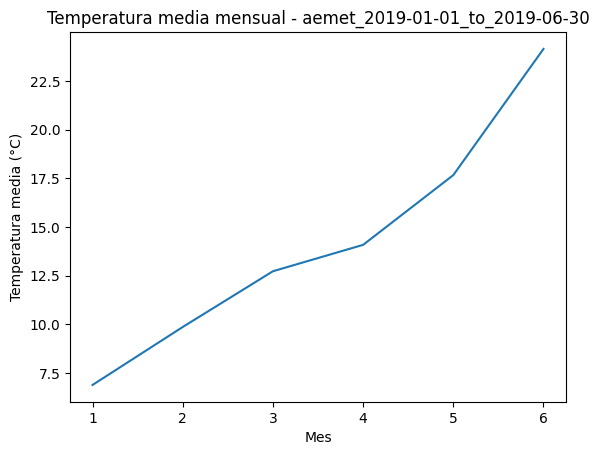

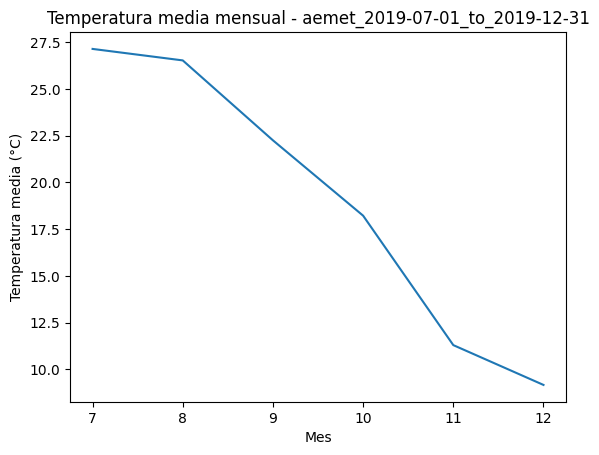

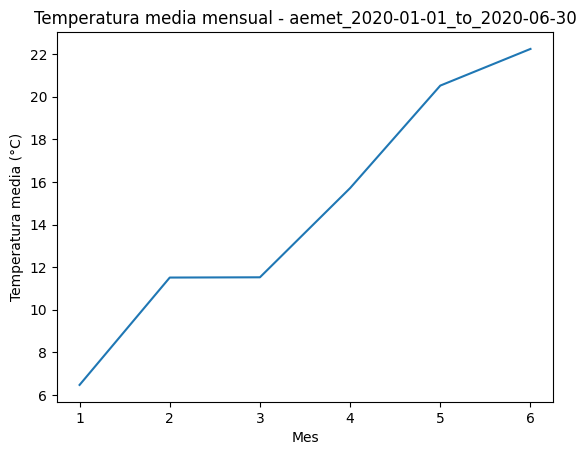

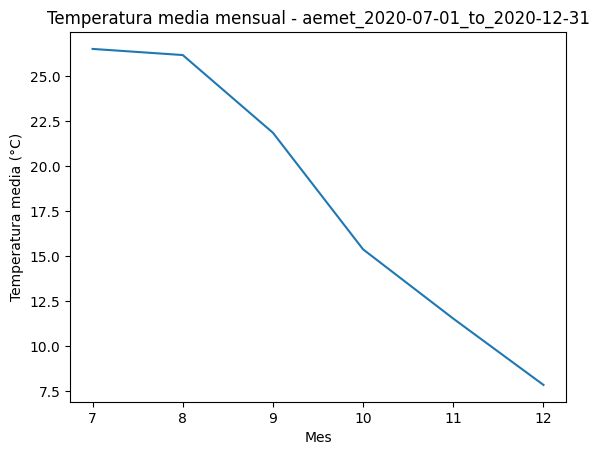

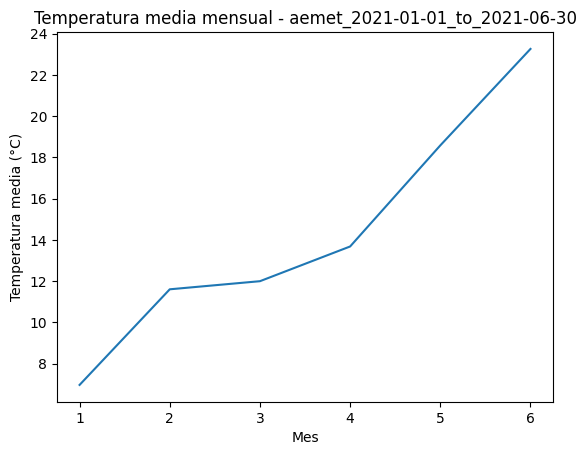

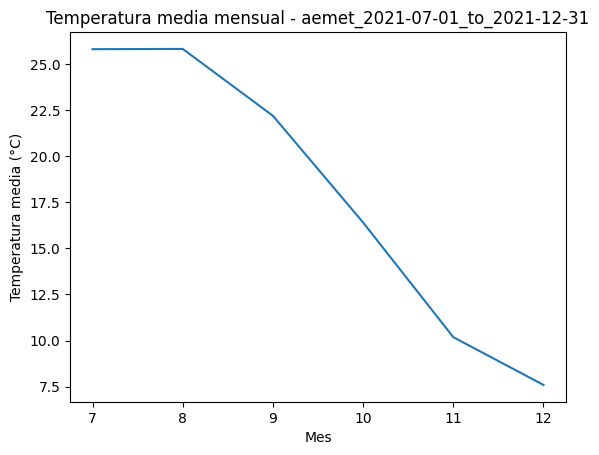

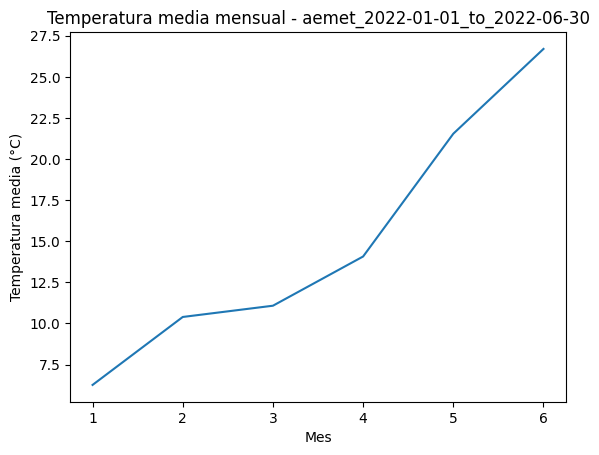

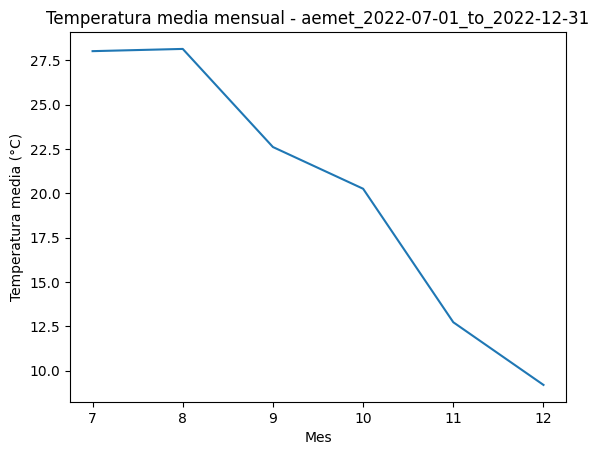

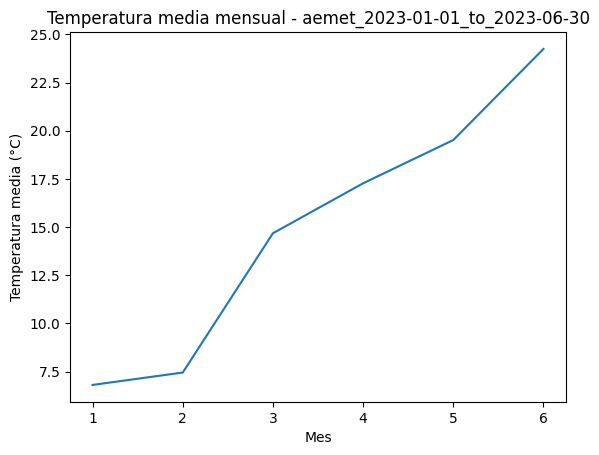

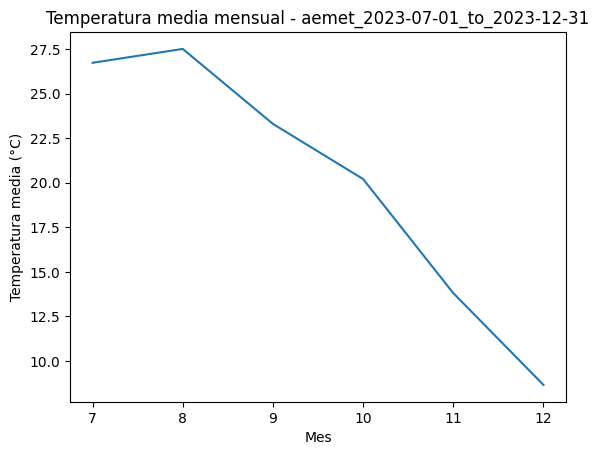

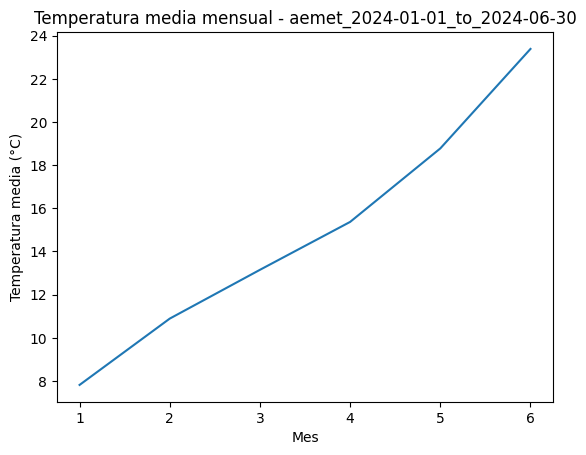

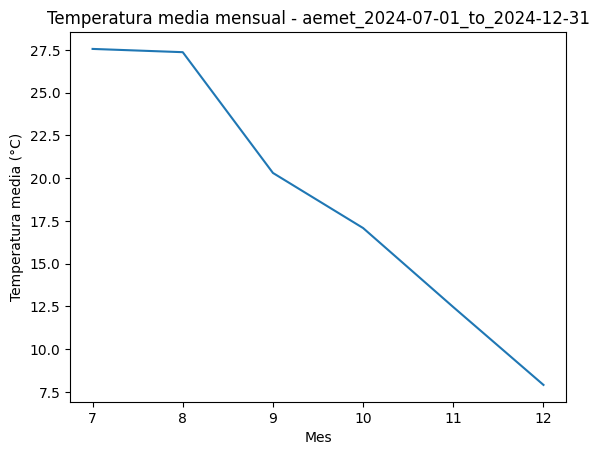

In [ ]:
import os
import glob
import json
import zipfile
import pandas as pd
import matplotlib.pyplot as plt


zip_path = "/content/CLIMA.zip"
extract_path = "/content/CLIMA"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)


files = glob.glob(os.path.join(extract_path, "**", "*.json"), recursive=True)

if len(files) == 0:
    raise ValueError(" No se encontraron archivos JSON en el ZIP")


def read_aemet(file):
    """Lee JSON AEMET en cualquiera de sus formatos conocidos."""
    try:
        with open(file, encoding="utf-8") as f:
            data = json.load(f)

        # Caso 1: JSON es lista
        if isinstance(data, list):
            df = pd.DataFrame(data)

        # Caso 2: JSON con clave 'datos'
        elif isinstance(data, dict) and "datos" in data:
            df = pd.DataFrame(data["datos"])

        else:
            return None

        # Columnas mínimas
        required_cols = ["fecha", "tmax", "tmin"]
        if not all(col in df.columns for col in required_cols):
            return None

        df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")

        # Estación = nombre del archivo
        df["estacion"] = os.path.basename(file).replace(".json", "")

        # Columnas opcionales
        for col in ["prec", "velmedia", "hrMedia"]:
            if col not in df.columns:
                df[col] = None

        df = df[["fecha", "estacion", "tmax", "tmin", "prec", "velmedia", "hrMedia"]]

        return df

    except Exception as e:
        print(f"⚠️ Error leyendo {file}: {e}")
        return None


dfs = [read_aemet(f) for f in files]
dfs = [df for df in dfs if df is not None]

if len(dfs) == 0:
    raise ValueError(" Ningún fichero JSON válido para procesar")

aemet_data = pd.concat(dfs, ignore_index=True)

aemet_data = aemet_data.iloc[:-3]


num_cols = ["tmax", "tmin", "prec", "velmedia", "hrMedia"]

for col in num_cols:
    aemet_data[col] = (
        aemet_data[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
    )
    aemet_data[col] = pd.to_numeric(aemet_data[col], errors="coerce")


aemet_data["año"] = aemet_data["fecha"].dt.year
aemet_data["mes"] = aemet_data["fecha"].dt.month
aemet_data["tmedia"] = (aemet_data["tmax"] + aemet_data["tmin"]) / 2


mensual = (
    aemet_data
    .groupby(["estacion", "año", "mes"], as_index=False)
    .mean(numeric_only=True)
)


media_global = (
    mensual
    .groupby("mes", as_index=False)
    .mean(numeric_only=True)
)


plt.figure()
plt.plot(media_global["mes"], media_global["tmedia"])
plt.xlabel("Mes")
plt.ylabel("Temperatura media (°C)")
plt.title("Temperatura media mensual (todas las estaciones)")
plt.show()


climatologia = media_global.rename(
    columns={"tmedia": "tmedia_clima"}
)

anomalias = media_global.merge(
    climatologia[["mes", "tmedia_clima"]],
    on="mes"
)

anomalias["anomalia"] = anomalias["tmedia"] - anomalias["tmedia_clima"]


plt.figure()
plt.bar(anomalias["mes"], anomalias["anomalia"])
plt.axhline(0)
plt.xlabel("Mes")
plt.ylabel("Anomalía térmica (°C)")
plt.title("Anomalías climáticas mensuales")
plt.show()


for est in mensual["estacion"].unique():
    df_est = mensual[mensual["estacion"] == est]

    plt.figure()
    plt.plot(df_est["mes"], df_est["tmedia"])
    plt.xlabel("Mes")
    plt.ylabel("Temperatura media (°C)")
    plt.title(f"Temperatura media mensual - {est}")
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
esperanza_file_path = "/content/esperanza de vida.csv"

try:
    esp_data = pd.read_csv(esperanza_file_path, encoding='latin1', sep=',')
except Exception as e:
    print(f"Error al cargar el archivo: {e}. Intentando con encoding por defecto.")
    esp_data = pd.read_csv(esperanza_file_path)

# Identify year and value columns
anyo_cols = [col for col in esp_data.columns if 'Data/' in col and 'Anyo' in col]
valor_cols = [col for col in esp_data.columns if 'Data/' in col and 'Valor' in col]

# Initialize an empty DataFrame for combined data
combined_data = pd.DataFrame()

# Iterate and concatenate year and value pairs
for i in range(len(anyo_cols)):
    temp_df = pd.DataFrame({
        'Año': esp_data[anyo_cols[i]].values,
        'Num_esperanza': esp_data[valor_cols[i]].values
    })
    combined_data = pd.concat([combined_data, temp_df], ignore_index=True)

# Remove rows with missing values and drop duplicates
combined_data = combined_data.dropna(subset=['Año', 'Num_esperanza']).drop_duplicates()

# Convert to numeric types
combined_data['Año'] = pd.to_numeric(combined_data['Año'], errors='coerce').astype(int)
combined_data['Num_esperanza'] = pd.to_numeric(combined_data['Num_esperanza'], errors='coerce')

# Assign the processed annual DataFrame to espv_data
espv_data = combined_data.copy()

display(espv_data.head(20))

Error al cargar el archivo: name 'pd' is not defined. Intentando con encoding por defecto.


NameError: name 'pd' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

esperanza_file_path = "/content/drive/MyDrive/esperanza de vida.csv"

try:
    esp_data = pd.read_csv(esperanza_file_path, encoding='latin1', sep=',')
except Exception as e:
    print(f"Error al cargar el archivo: {e}. Intentando con encoding por defecto.")
    esp_data = pd.read_csv(esperanza_file_path)

# Identify year and value columns
anyo_cols = [col for col in esp_data.columns if 'Data/' in col and 'Anyo' in col]
valor_cols = [col for col in esp_data.columns if 'Data/' in col and 'Valor' in col]

# Initialize an empty DataFrame for combined data
combined_data = pd.DataFrame()

# Iterate and concatenate year and value pairs
for i in range(len(anyo_cols)):
    temp_df = pd.DataFrame({
        'Año': esp_data[anyo_cols[i]].values,
        'Num_esperanza': esp_data[valor_cols[i]].values
    })
    combined_data = pd.concat([combined_data, temp_df], ignore_index=True)

# Remove rows with missing values and drop duplicates
combined_data = combined_data.dropna(subset=['Año', 'Num_esperanza']).drop_duplicates()

# Convert to numeric types
combined_data['Año'] = pd.to_numeric(combined_data['Año'], errors='coerce').astype(int)
combined_data['Num_esperanza'] = pd.to_numeric(combined_data['Num_esperanza'], errors='coerce')

# Assign the processed annual DataFrame to espv_data
espv_data = combined_data.copy()

display(espv_data.head(20))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

esperanza_file_path = "/content/drive/MyDrive/esperanza de vida.csv"

try:
    esp_data = pd.read_csv(esperanza_file_path, encoding='latin1', sep=',')
except Exception as e:
    print(f"Error al cargar el archivo: {e}. Intentando con encoding por defecto.")
    esp_data = pd.read_csv(esperanza_file_path)

# Identify year and value columns
anyo_cols = [col for col in esp_data.columns if 'Data/' in col and 'Anyo' in col]
valor_cols = [col for col in esp_data.columns if 'Data/' in col and 'Valor' in col]

# Initialize an empty DataFrame for combined data
combined_data = pd.DataFrame()

# Iterate and concatenate year and value pairs
for i in range(len(anyo_cols)):
    temp_df = pd.DataFrame({
        'Año': esp_data[anyo_cols[i]].values,
        'Num_esperanza': esp_data[valor_cols[i]].values
    })
    combined_data = pd.concat([combined_data, temp_df], ignore_index=True)

# Remove rows with missing values and drop duplicates
combined_data = combined_data.dropna(subset=['Año', 'Num_esperanza']).drop_duplicates()

# Convert to numeric types
combined_data['Año'] = pd.to_numeric(combined_data['Año'], errors='coerce').astype(int)
combined_data['Num_esperanza'] = pd.to_numeric(combined_data['Num_esperanza'], errors='coerce')

# Assign the processed annual DataFrame to espv_data
espv_data = combined_data.copy()

display(espv_data.head(20))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

esperanza_file_path = "/content/drive/MyDrive/esperanza de vida.csv"

try:
    esp_data = pd.read_csv(esperanza_file_path, encoding='latin1', sep=',')
except Exception as e:
    print(f"Error al cargar el archivo: {e}. Intentando con encoding por defecto.")
    esp_data = pd.read_csv(esperanza_file_path)

# Identify year and value columns
anyo_cols = [col for col in esp_data.columns if 'Data/' in col and 'Anyo' in col]
valor_cols = [col for col in esp_data.columns if 'Data/' in col and 'Valor' in col]

# Initialize an empty DataFrame for combined data
combined_data = pd.DataFrame()

# Iterate and concatenate year and value pairs
for i in range(len(anyo_cols)):
    temp_df = pd.DataFrame({
        'Año': esp_data[anyo_cols[i]].values,
        'Num_esperanza': esp_data[valor_cols[i]].values
    })
    combined_data = pd.concat([combined_data, temp_df], ignore_index=True)

# Remove rows with missing values and drop duplicates
combined_data = combined_data.dropna(subset=['Año', 'Num_esperanza']).drop_duplicates()

# Convert to numeric types
combined_data['Año'] = pd.to_numeric(combined_data['Año'], errors='coerce').astype(int)
combined_data['Num_esperanza'] = pd.to_numeric(combined_data['Num_esperanza'], errors='coerce')

# Assign the processed annual DataFrame to espv_data
espv_data = combined_data.copy()

display(espv_data.head(20))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Tarea 2: Análisis exploratorio de datos

### Análisis descriptivo y valores faltantes


Primero comenzaremos leyendo los datos ya limpios.

In [ ]:
# Cargamos los datos

El formato en el que están guardados es un *dataframe*. Es como una tabla donde cada fila es una instancia (o valor) y cada columna es una variable (año, PIB,...). Antes de comenzar el análisis, visualizar las primeras 6 filas del *dataframe* para aseguraros de que son los datos correctos.

In [ ]:
# Visualizar las primeras 6 filas de nuestro dataframe

Para conocer mejor nuestros datos, es útil saber también cuántos datos tenemos, cuántas filas y cuántas columnas

In [ ]:
# Mostrar el nº de filas y columnas. ¿Cuántos datos tenemos?

Antes de entrar en los valores, es relevante ver si la estructura del dataframe y el tipo de sus variables son las correctas.

In [ ]:
# Obtener la estructura del dataframe

Echemos un primer vistazo a los valores de las variables. Visualizar un pequeño resumen, ¿véis algo reseñable?

In [ ]:
# Visualizar un resumen de los valores de cada variable

Un aspecto a tener muy en cuenta son los valores faltantes de las variables. Mostrar esta información por pantalla.

In [ ]:
# ¿Cuántos valores faltantes hay en cada variable? ¿Observáis algo relevante para el estudio?

In [ ]:

import os
import glob
import json
import pandas as pd

df_csv = pd.read_csv("/content/AEMET.csv")
ruta = "/content/data/polut/*"
files = glob.glob(ruta)

dfs_json = []

for f in files:
    try:
        with open(f, encoding="utf-8") as file:
            data = json.load(file)   # 👈 aquí da igual la extensión

        if isinstance(data, list):
            df = pd.DataFrame(data)

        elif isinstance(data, dict) and "datos" in data:
            df = pd.DataFrame(data["datos"])

        else:
            continue

        dfs_json.append(df)

    except Exception as e:
        print(f"Saltado {f} (no es JSON válido)")

df_json_total = pd.concat(dfs_json, ignore_index=True)

En caso de que con la información anterior, o con la información futura del análisis, veáis conveniente para el estudio eliminar alguna variable, debéis hacerlo de manera justificada. Existe una función en python para eliminar columnas. Si lo hacéis, después debéis mostrar algun resumen de los anteriores para confirmar que habéis eliminado las variables con éxito.

Normalmente, es una buena idea representar gráficamente las variables que tenemos para visualizar rápidamente qué pinta tienen de cara a la modelización posterior, y si tienen sentido o, por el contrario, hemos hecho algo mal.
Para ello, os facilitamos un bucle utilizando la función `enumerate` que itere sobre todas las variables que nos quedan y que nos haga un gráfico para cada una, y disponga todos los gráficos conjuntamente.

> Pista: La función `enumerate` aplicada a un *dataframe* de Pandas en un bucle de Python devuelve dos elementos en cada iteración: (i,col) en este caso porque son los iteradores que hemos elegido. El primero hará referencia al número de iteración (aplicado a este caso al número de columna que se está procesando) y el segundo al valor de dicha iteración, en este caso el nombre de la columna. Por ejemplo, si la primera columna de mi dataframe se llama `year` en la primera iteración i tendrá el valor 0 (recordemos que Python empieza a contar en 0, no en 1) mientras que `col` tendrá el valor `year`. Es decir, devolverá (0,'year').

In [ ]:
# Visualizamos los datos
fig, axes = plt.subplots(..., ..., figsize=(..., ...)) # Ajustamos el 'layout' (disposición de los gráficos)
axes = axes.flatten()

# Iteramos sobre todas las columnas para representar todas las variables
for i, col in enumerate(data.columns):
    axes[i].plot(...) # La clave es que el código vaya seleccionando de los datos una columna en cada iteración
    axes[i].set_title(...) # Para luego identificar los gráficos, colocaremos el nombre de la variable que estamos procesando como título

# Ocultamos subplot vacío (el #...)
for j in range(len(data.columns), ...):
    axes[j].axis('off')

plt.tight_layout()
plt.show() # Mostramos el gráfico

Rellenando los huecos del bucle anterior, sacaréis por pantalla un tipo de gráfico. ¿Qué se observa en cada una de las variables? -> describir.

Para continuar nuestro análisis exploratorio es de interés conocer la distribución de las variables. -> ¿Veis algo interesante en alguna de las variables?
¿Qué significa que la distribución es simétrica? ¿Y que es asimétrica la derecha? ¿Y a la izquierda?
Recordar que algunas variables están duplicadas.
Para visualizar la distribución se debe utilizar el bucle explicado anteriormente, cambiando el tipo de gráfica que se emplea. Justifica la información que nos da cada uno de ellos.

### Valores atípicos

Un paso importante en el análisis exploratorio es la detección y el tratamiento de valores atípicos en las variables. Para ello, os vamos a facilitar dos formas complementarias de extraer esta información.

Una función es un conjunto de instrucciones cerradas de código que reciben una serie de argumentos a las que luego le aplican dichas instrucciones. En las librerías que hemos cargado inicialmente había muchas funciones que ya estaban creadas por los desarrolladores de esas librerías (por ejemplo, `read_csv()` o la citada `enumerate` empleada en el chunk anterior. No obstante, nosotros podemos crear nuestras propias funciones que hagan lo que nosotros les programemos. En el siguiente chunk deberéis ejecutar una función que hemos programado, con el objetivo de poder utilizarla más adelante.

Esta función recibe como entrada un vector numérico de datos y devuelve la posición dentro del objeto y el valor de los datos atípicos (si existen) de acuerdo a la siguiente expresión:

\begin{aligned}
q &< Q_{1} - 1.5 \cdot \mathrm{IQR} \\
\text{o} \\
q &> Q_{3} + 1.5 \cdot \mathrm{IQR}
\end{aligned}


In [ ]:
def detect_outliers(data):
    """
    Calcula la posición (índice) y el valor de los outliers
    en un vector numérico utilizando la regla 1.5 * IQR.
    """
    import numpy as np
    import pandas as pd
    # Preparar la entrada y obtener un array de NumPy
    if isinstance(data, pd.Series):
        # Si es una Serie de Pandas, extraemos solo los valores para el cálculo
        x_values = data.values
    else:
        x_values = np.array(data)

    # Validación de tipo de datos (ahora sobre los valores numéricos)
    # Verificamos si el dtype del array es numérico (int, float)
    if not np.issubdtype(x_values.dtype, np.number):
        raise ValueError("El vector ingresado debe ser numérico.")

    x = x_values  # Usamos el array numérico para el resto del cálculo

    # Cálculo de Cuartiles y IQR
    q1 = np.quantile(x, 0.25)
    q3 = np.quantile(x, 0.75)
    iqr = q3 - q1

    # Definición de límites y detección de outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Encontrar las posiciones (índices) y valores
    outlier_mask = (x < lower_bound) | (x > upper_bound)
    values = x[outlier_mask].tolist()

    # Manejo de la posición: Devolver el índice original si es una Serie de Pandas
    if isinstance(data, pd.Series):
        # Retorna el índice (etiqueta) original de la fila del DataFrame
        positions = data[outlier_mask].index.tolist()
    else:
        # Retorna el índice de posición (0, 1, 2, ...) para listas/arrays
        positions = np.where(outlier_mask)[0].tolist()

    # Devolver el resultado
    return {
        'posiciones': positions,
        'valores': values
}

Utilizando nuestra función `detect_outliers`, comprobar si existen outliers en alguna variable de nuestros datos. Podemos utilizar un bucle, tal y como ya hemos aprendido, para aplicar esta función a todas las variables, guardando el resultado en un objeto llamado `outliers`.

In [ ]:
# Queremos saber si existen valores atípicos en alguna variable. Para ello, podemos iterar sobre todas las columnas de
# nuestro data frame y comprobarlo usando nuestra función "detect_outliers" para cada una de ellas. Nótese que, en Python,
# para seleccionar todas las filas de un data frame, deberemos emplear el operador ":" junto con la función "iloc"
# sobre la columna en cuestión "i = 1,2,..., n"
outliers = {} # Creamos un objeto vacío para alamacenar los posibles 'outliers'
# Iteramos sobre todas las variables de nuestros datos
for i in range(...):
    outliers[data.columns[...]] = detect_outliers(data=data.iloc[:, ...]) # Almacenamos los resultados en el objeto creado previamente
print(outliers) # Una vez que el bucle termina, podemos visualizar todos los resultados
outliers['no2'] # O puede ser que nos interese hacerlo parcialmente, por ejemplo sólo los de la contaminación

Otra manera de revisar si hay valores atípicos es utilizando un tipo de gráfico idóneo para ello sobre las variables.

In [ ]:
# Emplead el bucle facilitado anteriormente para graficar cada variable.
# Únicamente debéis cambiar la función que dicta el tipo de gráfico que se realiza, eligiendo el adecuado
# para detectar valores atípicos

Interpretar los resultados. ¿Qué significa la longitud de las cajas? ¿Y de los bigotes? ¿Qué son los puntos fuera de los bigotes y las cajas?

¿Observas algo interesante? ¿Cómo se deberían tratar estos outliers?

### Correlaciones

Hasta ahora hemos estado analizando cada variable por individual, pero en nuestra investigación nos va ayudar conocer cómo se relaciona cada variable con el resto. Para ello, se estudia la correlación de las variables.

In [ ]:
# Emplead una función directa para conocer los coeficientes de correlación de cada par de variables

¿Qué significan los valores calculados? ¿Qué información relevante extraemos de ellos?

Centrémonos en nuestra variable objetivo. Para finalizar nuestro análisis exploratorio de datos, nos puede dar una información relevante de cara a la modelización conocer más detalladamente cómo se correlaciona la variable objetivo con el resto. Para ello, emplead el bucle de gráficas facilitado anteriormente, y seleccionad el tipo de gráfico adecuado para visualizar la correlación entre dos variables.

In [ ]:
# Emplead el bucle facilitado anteriormente para graficar la correlación de la variable objetivo vs el resto.
# Únicamente debéis cambiar la función que dicta el tipo de gráfico que se realiza, eligiendo el adecuado
# para mostrar la correlación entre dos variables.

¿Qué observáis? ¿Podéis extraer alguna idea inicial de la relación entre las variables, y en particular, entre la variable objetivo con las demás?

¿Qué conclusiones se pueden extraer del análisis exploratorio de datos realizado?